In [1]:
# setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from statannot import add_stat_annotation
from itertools import count
import os, mne

# calculate the Cohen's d between two samples
from numpy.random import randn
from numpy.random import seed
from numpy import mean
from numpy import var
from math import sqrt

# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = mean(d1), mean(d2)
    return (u1 - u2) / s

    
class EEGChannel:
    '''innitilized by info chs'''
    _ids = count(0)
    
    def __init__(self, x, y,name="None"):
        self.id = next(self._ids)
        self.x = x
        self.y = y
        self.name = name
    def plot(self,ax,center):
        circle = plt.Circle((center[0]+self.x, center[1]+self.y), radius=0.2,fill = True)
        ax.add_patch(circle)
        label = ax.annotate(self.name, xy=(center[0]+self.x, center[1]+self.y), fontsize=18, ha="center")
        return ax 
    
class EMGChannel:
    '''with polar coordinates as inputs'''
    
    _ids = count(0)
    
    def __init__(self, rho, phi,name="None"):
        self.id = next(self._ids)
        self.rho = rho
        self.phi = phi
        self.name = name
        self.x = rho * np.cos(phi/180*np.pi)
        self.y = rho * np.sin(phi/180*np.pi)
        
    def plot(self,ax,center):
        circle = plt.Circle((center[0]+self.x, center[1]+self.y), radius=0.2,fill = True)
        ax.add_patch(circle)
        label = ax.annotate(self.name, xy=(center[0]+self.x, center[1]+self.y), fontsize=18, ha="center")
        return ax        
    
    def cartesianC(self):
        return(self.x, self.y)
    
    def polarC(self):
        return(self.rho,self.phi)

    
chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']


################## Dataset Loading ##################
data_dir = 'D:/Data/MultiEEGEMG_stroke/'
preVsPostTMS_results_dir = os.path.join(data_dir,'results','preVsPostTMS')
if not os.path.exists(preVsPostTMS_results_dir):
    os.makedirs(preVsPostTMS_results_dir)
# data_dir = 'E:/important file/Projects/CM-graph/sample_data' #PC dir
subj_idx = '15'
contraction_type = 'iMC'
session_idx = 's01'
subjInfo_fName = os.path.join(data_dir,'subj_info.txt')
subjInfo = pd.read_csv(subjInfo_fName, skiprows=0,
                       sep = ',',engine = 'python')

results_dir = os.path.join(data_dir,'subj'+subj_idx,'results')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

epochs_hybrid_dir = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid')
epochs_hybrid_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_hybrid_epo.fif')
epochs_hybrid = mne.read_epochs(epochs_hybrid_fName,preload=True)

EMGs=[EMGChannel(2,150,'emg1'),EMGChannel(2,170,'emg2'),EMGChannel(2, 240,'emg3'),EMGChannel(2,350,'emg4'),
      EMGChannel(2, 80,'emg5'),EMGChannel(4,140,'emg6'),EMGChannel(4, 310,'emg7'),
      EMGChannel(4,90,'emg8')]

EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][0]*50,
           y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][1]*50,
           name=ch) for ch in chs_list_image[:32]]  

Reading D:/Data/MultiEEGEMG_stroke/subj15\epochs_hybrid\subj15_iMC_s01_hybrid_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
45 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


# Dataframe engineering

In [2]:
import os

stroke_subj = ['25','24','20','10','30','32','34','35']
# data_dir = 'E:/important file/Projects/CM-graph/sample_data' #PC dir
global_results_dir = os.path.join(data_dir,'results')
contraction_type = 'iMC'
if not os.path.exists(global_results_dir):
    os.makedirs(global_results_dir)
    
subjInfo_fName = os.path.join(data_dir,'subj_info.txt')
subjInfo = pd.read_csv(subjInfo_fName, skiprows=0,
                       sep = ',',engine = 'python')    
df_preTMS2concat=[]
df_postTMS2concat=[]
for subj_idx in stroke_subj:
    df_g_preTMS_fName = os.path.join(data_dir,'subj'+subj_idx,'temp',
                            'subj'+subj_idx+contraction_type+'_s01_gProperties.xlsx')
    df_g_preTMS = pd.read_excel(df_g_preTMS_fName)
    df_info = subjInfo[subjInfo['subj_idx']==int(subj_idx)]
    df_g_preTMS.reset_index(drop=True,inplace=True)
    df_info.reset_index(drop=True,inplace=True)
    df = pd.concat([df_info,df_g_preTMS],axis=1)
    df_preTMS2concat.append(df)
    
    df_g_postTMS_fName = os.path.join(data_dir,'subj'+subj_idx,'temp',
                            'subj'+subj_idx+contraction_type+'_s02_gProperties.xlsx')
    df_g_postTMS = pd.read_excel(df_g_postTMS_fName)
    df_info = subjInfo[subjInfo['subj_idx']==int(subj_idx)]
    df_g_postTMS.reset_index(drop=True,inplace=True)
    df_info.reset_index(drop=True,inplace=True)
    df = pd.concat([df_info,df_g_postTMS],axis=1)
    df_postTMS2concat.append(df)    
    
df_preTMS = pd.concat(df_preTMS2concat,sort=False)    
group = ['preTMS']*df_preTMS.shape[0]
df_preTMS['group'] = group
  
df_postTMS = pd.concat(df_postTMS2concat,sort=False)
group = ['postTMS']*df_postTMS.shape[0]
df_postTMS['group'] = group

df_prePostTMS = pd.concat([df_preTMS,df_postTMS],sort=False)

In [11]:
# visualize cols
df_prePostTMS.loc[:,['Fp1i_cost_ecc_weight','subj_idx']]

,Fp1i_cost_ecc_weight,subj_idx
0,0.381632,25
0,0.562149,24
0,0.500592,20
0,0.380560,10
0,0.311150,30
0,0.381110,32
0,0.433797,34
0,0.341102,35
0,0.524792,25
0,0.505860,24


# graph properties test
## global properties - t_test ind

In [3]:
list_gProperties =['diameter', 'density', 's_metric', 'transitivity', 'local_efficiency', 'global_efficiency',
                   'sw_omega', 'node_connectivity_wholeG',
                   'wiener_idx', 'wiener_idx_weight', 'size','size_weight','assortativityCoefficient',
                   'cost_size_weight', 'cost_wiener_index_weight',
                   'mean_clusteringC', 'g_cliqueNumber', 'g_numberOfMaxClique','non_randomness','relative_nonRandomness',
                   'wiener_idx_minST_weight', 'wiener_idx_maxST_weight','size_minST_weight','size_maxST_weight'
                  ] 
for gProperty in list_gProperties:    
    t_stat,pvalue = scipy.stats.ttest_ind((df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty],
                          (df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty], equal_var=False)
    cohen_s_d = round(cohend((df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty],
                 (df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty]),2)
#     p_eigenvectorC[gProperty.split('_')[0]]=pvalue
    print(gProperty + ": pvalue = {}, cohen's d = {}, t_stat = {}".format(round(pvalue,2),cohen_s_d,round(t_stat,2)))
    

diameter: pvalue = nan, cohen's d = nan, t_stat = nan
density: pvalue = 0.49, cohen's d = -0.35, t_stat = -0.71
s_metric: pvalue = 0.46, cohen's d = -0.38, t_stat = -0.75
transitivity: pvalue = 0.51, cohen's d = -0.34, t_stat = -0.67
local_efficiency: pvalue = 0.58, cohen's d = -0.28, t_stat = -0.57
global_efficiency: pvalue = 0.49, cohen's d = -0.35, t_stat = -0.71
sw_omega: pvalue = 0.31, cohen's d = -0.54, t_stat = -1.08
node_connectivity_wholeG: pvalue = 0.16, cohen's d = -0.75, t_stat = -1.51
wiener_idx: pvalue = 0.49, cohen's d = 0.35, t_stat = 0.71
wiener_idx_weight: pvalue = 0.55, cohen's d = -0.31, t_stat = -0.61
size: pvalue = 0.49, cohen's d = -0.35, t_stat = -0.71
size_weight: pvalue = 0.75, cohen's d = -0.16, t_stat = -0.32
assortativityCoefficient: pvalue = 0.54, cohen's d = 0.32, t_stat = 0.63
cost_size_weight: pvalue = 0.89, cohen's d = 0.07, t_stat = 0.15
cost_wiener_index_weight: pvalue = 0.2, cohen's d = 0.68, t_stat = 1.36
mean_clusteringC: pvalue = 0.45, cohen's d 

d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


## global properties rmANOVA

In [40]:
from statsmodels.stats.anova import AnovaRM
list_gProperties =['diameter', 'density', 's_metric', 'transitivity', 'local_efficiency', 'global_efficiency',
                   'sw_omega', 'node_connectivity_wholeG',
                   'wiener_idx', 'wiener_idx_weight', 'size','size_weight','assortativityCoefficient',
                   'cost_size_weight', 'cost_wiener_index_weight',
                   'mean_clusteringC', 'g_cliqueNumber', 'g_numberOfMaxClique','non_randomness','relative_nonRandomness',
                   'wiener_idx_minST_weight', 'wiener_idx_maxST_weight','size_minST_weight','size_maxST_weight'
                  ] 
for gProperty in list_gProperties:
    aovrm = AnovaRM(df_prePostTMS,gProperty,'subj_idx',within=['group'])
    res=aovrm.fit()
    if res.anova_table.get('Pr > F').item()<0.5:
            print(gProperty)
            print(res)
    

cost_wiener_index_weight
              Anova
      F Value Num DF Den DF Pr > F
----------------------------------
group  0.6077 1.0000 4.0000 0.4792



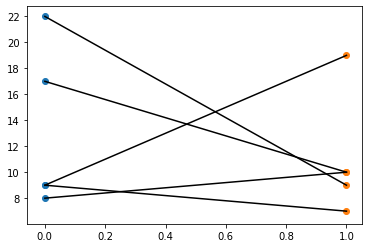

In [53]:
#  paired points boxplot - cost_wiener_index_weight
plt.scatter(np.zeros(len(stroke_subj)),df_prePostTMS[df_prePostTMS['group']=='preTMS']['node_connectivity_wholeG'])
plt.scatter(np.ones(len(stroke_subj)),df_prePostTMS[df_prePostTMS['group']=='postTMS']['node_connectivity_wholeG'])

#for i in range(len(stroke_subj)):
#    plt.plot([0,1],[df_prePostTMS[df_prePostTMS['group']=='preTMS']['cost_wiener_index_weight'][i],
#                   df_prePostTMS[df_prePostTMS['group']=='postTMS']['cost_wiener_index_weight'][i]],c='k')
plt.plot([0,1],[df_prePostTMS[df_prePostTMS['group']=='preTMS']['node_connectivity_wholeG'],
                df_prePostTMS[df_prePostTMS['group']=='postTMS']['node_connectivity_wholeG']],c='k')

## degreeC

In [28]:
p_degreeC = {key:None for key in chs_list_image}
list_gProperties =['Fp1i_degree_centrality', 'AF3i_degree_centrality', 'F3i_degree_centrality',
                   'F7i_degree_centrality', 'FC1i_degree_centrality', 'FC5i_degree_centrality',
                   'C3i_degree_centrality', 'T7i_degree_centrality', 'CP1i_degree_centrality',
                   'CP5i_degree_centrality', 'P3i_degree_centrality', 'P7i_degree_centrality',
                   'PO3i_degree_centrality', 'O1i_degree_centrality', 'Fz_degree_centrality',
                   'Cz_degree_centrality', 'Pz_degree_centrality', 'Oz_degree_centrality',
                   'Fp1c_degree_centrality', 'AF3c_degree_centrality', 'F3c_degree_centrality', 
                   'F7c_degree_centrality', 'FC1c_degree_centrality', 'FC5c_degree_centrality', 
                   'C3c_degree_centrality', 'T8c_degree_centrality', 'CP1c_degree_centrality', 
                   'CP5c_degree_centrality', 'P3c_degree_centrality', 'P7c_degree_centrality',
                   'PO3c_degree_centrality', 'O1c_degree_centrality','emg1_degree_centrality',
                   'emg2_degree_centrality','emg3_degree_centrality','emg4_degree_centrality',
                   'emg5_degree_centrality','emg6_degree_centrality','emg7_degree_centrality',
                   'emg8_degree_centrality'] 
for gProperty in list_gProperties:    
    t_stat,pvalue = scipy.stats.ttest_ind((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                          (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty], equal_var=False)
    cohen_s_d = round(cohend((df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty],
                 (df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty]),2)
    p_degreeC[gProperty.split('_')[0]]=pvalue
    print(gProperty + ": pvalue = {}, cohen's d = {}, t_stat = {}".format(round(pvalue,2),cohen_s_d,round(t_stat,2)))
    

Fp1i_degree_centrality: pvalue = 0.55, cohen's d = -0.31, t_stat = 0.62
AF3i_degree_centrality: pvalue = 0.89, cohen's d = 0.07, t_stat = -0.14
F3i_degree_centrality: pvalue = 0.78, cohen's d = 0.14, t_stat = -0.28
F7i_degree_centrality: pvalue = 0.55, cohen's d = 0.31, t_stat = -0.62
FC1i_degree_centrality: pvalue = 0.45, cohen's d = -0.39, t_stat = 0.78
FC5i_degree_centrality: pvalue = 0.22, cohen's d = -0.64, t_stat = 1.28
C3i_degree_centrality: pvalue = 0.83, cohen's d = -0.11, t_stat = 0.23
T7i_degree_centrality: pvalue = 0.19, cohen's d = -0.71, t_stat = 1.42
CP1i_degree_centrality: pvalue = 0.07, cohen's d = -1.02, t_stat = 2.03
CP5i_degree_centrality: pvalue = 0.14, cohen's d = -0.79, t_stat = 1.58
P3i_degree_centrality: pvalue = 0.07, cohen's d = -1.04, t_stat = 2.07
P7i_degree_centrality: pvalue = 0.74, cohen's d = 0.17, t_stat = -0.35
PO3i_degree_centrality: pvalue = 0.33, cohen's d = -0.51, t_stat = 1.02
O1i_degree_centrality: pvalue = 0.73, cohen's d = -0.18, t_stat = 0.35

In [29]:
from statsmodels.stats.anova import AnovaRM
p_degreeC = {key:None for key in chs_list_image}
for gProperty in list_gProperties: 
    aovrm = AnovaRM(df_prePostTMS,gProperty,'subj_idx',within=['group'])
    res=aovrm.fit()
    p_degreeC[gProperty.split('_')[0]]=res.anova_table.get('Pr > F').item()
    if res.anova_table.get('Pr > F').item()<0.05:
        print(gProperty)
        print(res)

emg5_degree_centrality
              Anova
      F Value Num DF Den DF Pr > F
----------------------------------
group  6.3602 1.0000 7.0000 0.0397



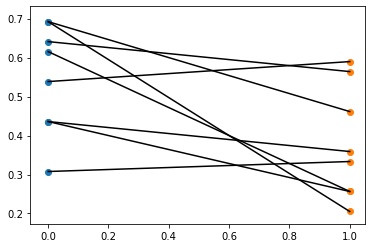

In [54]:
#  paired points boxplot - cost_wiener_index_weight
plt.scatter(np.zeros(len(stroke_subj)),df_prePostTMS[df_prePostTMS['group']=='preTMS']['emg5_degree_centrality'])
plt.scatter(np.ones(len(stroke_subj)),df_prePostTMS[df_prePostTMS['group']=='postTMS']['emg5_degree_centrality'])

#for i in range(len(stroke_subj)):
#    plt.plot([0,1],[df_prePostTMS[df_prePostTMS['group']=='preTMS']['cost_wiener_index_weight'][i],
#                   df_prePostTMS[df_prePostTMS['group']=='postTMS']['cost_wiener_index_weight'][i]],c='k')
plt.plot([0,1],[df_prePostTMS[df_prePostTMS['group']=='preTMS']['emg5_degree_centrality'],
                df_prePostTMS[df_prePostTMS['group']=='postTMS']['emg5_degree_centrality']],c='k')

Text(10, 10.8, '<0.001')

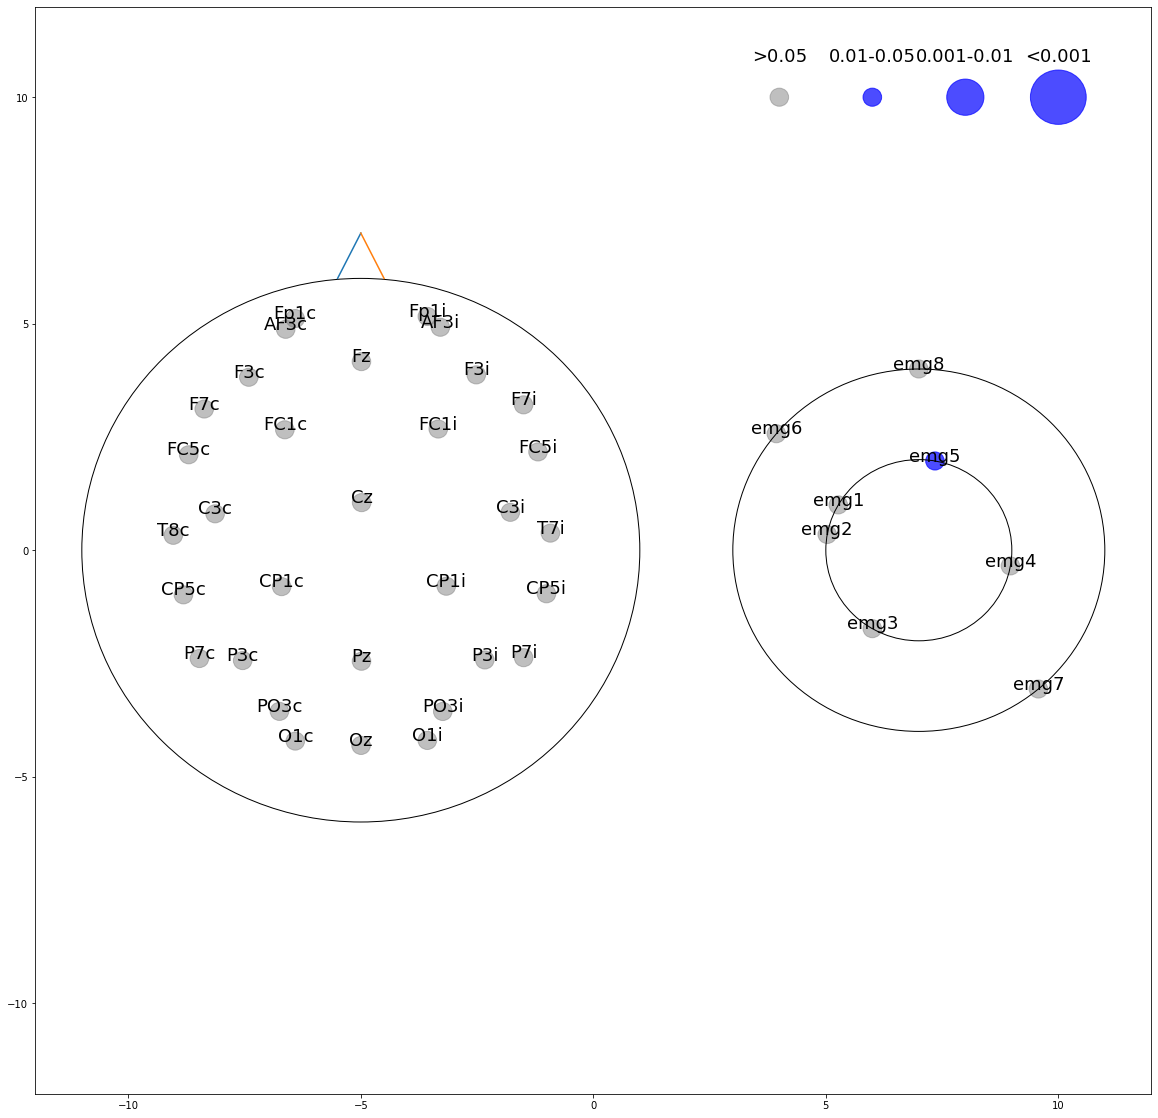

In [19]:
#visualisation
pvalue_levels = [0.05,0.01,0.001]
def radiusBasedOnP (pvalue, defaultR=0.2):
    radius = None
    for level_idx in range(len(pvalue_levels)):
        if pvalue <= pvalue_levels[level_idx]:
            if radius == None:
                radius = defaultR
            else: 
                radius += defaultR
        else:
            return radius
    return radius


fig,ax = plt.subplots(figsize=(20, 20))
ax = plt.gca()
# EEG
center=[-5,0]
radius=6
circle = plt.Circle((center[0],center[1]),radius,fill = False)
ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.add_artist(circle)
#EEG_chs
for EEG in EEGs:
    radius = radiusBasedOnP(p_degreeC[EEG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EEG.name, xy=(center[0]+EEG.x, center[1]+EEG.y), fontsize=18, color ='black', ha="center")

#EMG
center=[7,0]
for i in range(2):
    circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
    ax.add_artist(circle)
#EMG_chs
for EMG in EMGs:
    radius = radiusBasedOnP(p_degreeC[EMG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EMG.name, xy=(center[0]+EMG.x, center[1]+EMG.y), fontsize=18, color ='black', ha="center")
    
plt.xlim(-12,12)
plt.ylim(-12,12)


circle = plt.Circle((4,10), radius=0.2,fill = True, color = 'grey',alpha=0.5)
ax.add_patch(circle)
ax.annotate('>'+str(pvalue_levels[0]), xy=(4,10.8), fontsize=18, color ='black', ha="center")
increment = 0
for pvalue_level in pvalue_levels[1:]:
    increment+=1
    circle = plt.Circle((4+increment*2,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(str(pvalue_levels[increment])+'-'+str(pvalue_levels[increment-1]),
                xy=(4+increment*2,10.8), fontsize=18, color ='black', ha="center")
    
increment+=1    
circle = plt.Circle((4+2*increment,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
ax.add_patch(circle)
ax.annotate('<'+str(pvalue_levels[-1]), xy=(4+2*increment,10.8), 
            fontsize=18, color ='black', ha="center")

# save fig
# fName = os.path.join(preVsPostTMS_results_dir,'degreeC_topo.eps')
# plt.savefig(fName)

## cost_ecc_weight

In [4]:
p_cost_ecc_weight = {key:None for key in chs_list_image}
list_gProperties =['Fp1i_cost_ecc_weight', 'AF3i_cost_ecc_weight', 'F3i_cost_ecc_weight',
                   'F7i_cost_ecc_weight', 'FC1i_cost_ecc_weight', 'FC5i_cost_ecc_weight',
                   'C3i_cost_ecc_weight', 'T7i_cost_ecc_weight', 'CP1i_cost_ecc_weight',
                   'CP5i_cost_ecc_weight', 'P3i_cost_ecc_weight', 'P7i_cost_ecc_weight',
                   'PO3i_cost_ecc_weight', 'O1i_cost_ecc_weight', 'Fz_cost_ecc_weight',
                   'Cz_cost_ecc_weight', 'Pz_cost_ecc_weight', 'Oz_cost_ecc_weight',
                   'Fp1c_cost_ecc_weight', 'AF3c_cost_ecc_weight', 'F3c_cost_ecc_weight', 
                   'F7c_cost_ecc_weight', 'FC1c_cost_ecc_weight', 'FC5c_cost_ecc_weight', 
                   'C3c_cost_ecc_weight', 'T8c_cost_ecc_weight', 'CP1c_cost_ecc_weight', 
                   'CP5c_cost_ecc_weight', 'P3c_cost_ecc_weight', 'P7c_cost_ecc_weight',
                   'PO3c_cost_ecc_weight', 'O1c_cost_ecc_weight','emg1_cost_ecc_weight',
                   'emg2_cost_ecc_weight','emg3_cost_ecc_weight','emg4_cost_ecc_weight',
                   'emg5_cost_ecc_weight','emg6_cost_ecc_weight','emg7_cost_ecc_weight',
                   'emg8_cost_ecc_weight'] 
for gProperty in list_gProperties:    
    t_stat,pvalue = scipy.stats.ttest_ind((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                          (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty], equal_var=False)
    cohen_s_d = round(cohend((df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty],
                 (df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty]),2)
    p_cost_ecc_weight[gProperty.split('_')[0]]=pvalue
    print(gProperty + ": pvalue = {}, cohen's d = {}, t_stat = {}".format(round(pvalue,2),cohen_s_d,round(t_stat,2)))


Fp1i_cost_ecc_weight: pvalue = 0.17, cohen's d = 0.72, t_stat = -1.44
AF3i_cost_ecc_weight: pvalue = 0.17, cohen's d = 0.73, t_stat = -1.47
F3i_cost_ecc_weight: pvalue = 0.13, cohen's d = 0.81, t_stat = -1.63
F7i_cost_ecc_weight: pvalue = 0.09, cohen's d = 0.91, t_stat = -1.82
FC1i_cost_ecc_weight: pvalue = 0.03, cohen's d = 1.23, t_stat = -2.47
FC5i_cost_ecc_weight: pvalue = 0.12, cohen's d = 0.83, t_stat = -1.67
C3i_cost_ecc_weight: pvalue = 0.05, cohen's d = 1.11, t_stat = -2.22
T7i_cost_ecc_weight: pvalue = 0.17, cohen's d = 0.73, t_stat = -1.45
CP1i_cost_ecc_weight: pvalue = 0.06, cohen's d = 1.02, t_stat = -2.04
CP5i_cost_ecc_weight: pvalue = 0.26, cohen's d = 0.6, t_stat = -1.2
P3i_cost_ecc_weight: pvalue = 0.33, cohen's d = 0.5, t_stat = -1.01
P7i_cost_ecc_weight: pvalue = 0.11, cohen's d = 0.87, t_stat = -1.74
PO3i_cost_ecc_weight: pvalue = 0.02, cohen's d = 1.31, t_stat = -2.61
O1i_cost_ecc_weight: pvalue = 0.01, cohen's d = 1.55, t_stat = -3.09
Fz_cost_ecc_weight: pvalue = 0

In [25]:
from statsmodels.stats.anova import AnovaRM
p_cost_ecc_weight = {key:None for key in chs_list_image}
for gProperty in list_gProperties: 
    aovrm = AnovaRM(df_prePostTMS,gProperty,'subj_idx',within=['group'])
    res=aovrm.fit()
    p_cost_ecc_weight[gProperty.split('_')[0]]=res.anova_table.get('Pr > F').item()
    if res.anova_table.get('Pr > F').item()<0.05:
            print(gProperty)
            print(res)

FC1i_cost_ecc_weight
              Anova
      F Value Num DF Den DF Pr > F
----------------------------------
group  9.8217 1.0000 7.0000 0.0165

C3i_cost_ecc_weight
              Anova
      F Value Num DF Den DF Pr > F
----------------------------------
group  8.3314 1.0000 7.0000 0.0234

CP1i_cost_ecc_weight
              Anova
      F Value Num DF Den DF Pr > F
----------------------------------
group  8.2754 1.0000 7.0000 0.0238

PO3i_cost_ecc_weight
              Anova
      F Value Num DF Den DF Pr > F
----------------------------------
group 12.0823 1.0000 7.0000 0.0103

O1i_cost_ecc_weight
              Anova
      F Value Num DF Den DF Pr > F
----------------------------------
group 13.7002 1.0000 7.0000 0.0076

Pz_cost_ecc_weight
              Anova
      F Value Num DF Den DF Pr > F
----------------------------------
group  6.4167 1.0000 7.0000 0.0391

Fp1c_cost_ecc_weight
              Anova
      F Value Num DF Den DF Pr > F
----------------------------------
group  6.02

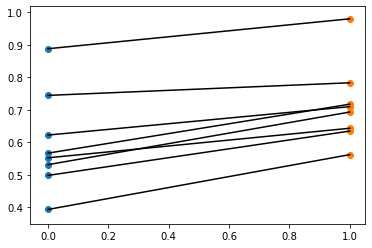

In [30]:
#  paired points boxplot - cost_wiener_index_weight
plt.scatter(np.zeros(len(stroke_subj)),df_prePostTMS[df_prePostTMS['group']=='preTMS']['emg1_cost_ecc_weight'])
plt.scatter(np.ones(len(stroke_subj)),df_prePostTMS[df_prePostTMS['group']=='postTMS']['emg1_cost_ecc_weight'])

plt.plot([0,1],[df_prePostTMS[df_prePostTMS['group']=='preTMS']['emg1_cost_ecc_weight'],
                df_prePostTMS[df_prePostTMS['group']=='postTMS']['emg1_cost_ecc_weight']],c='k')

Text(10, 10.8, '<0.001')

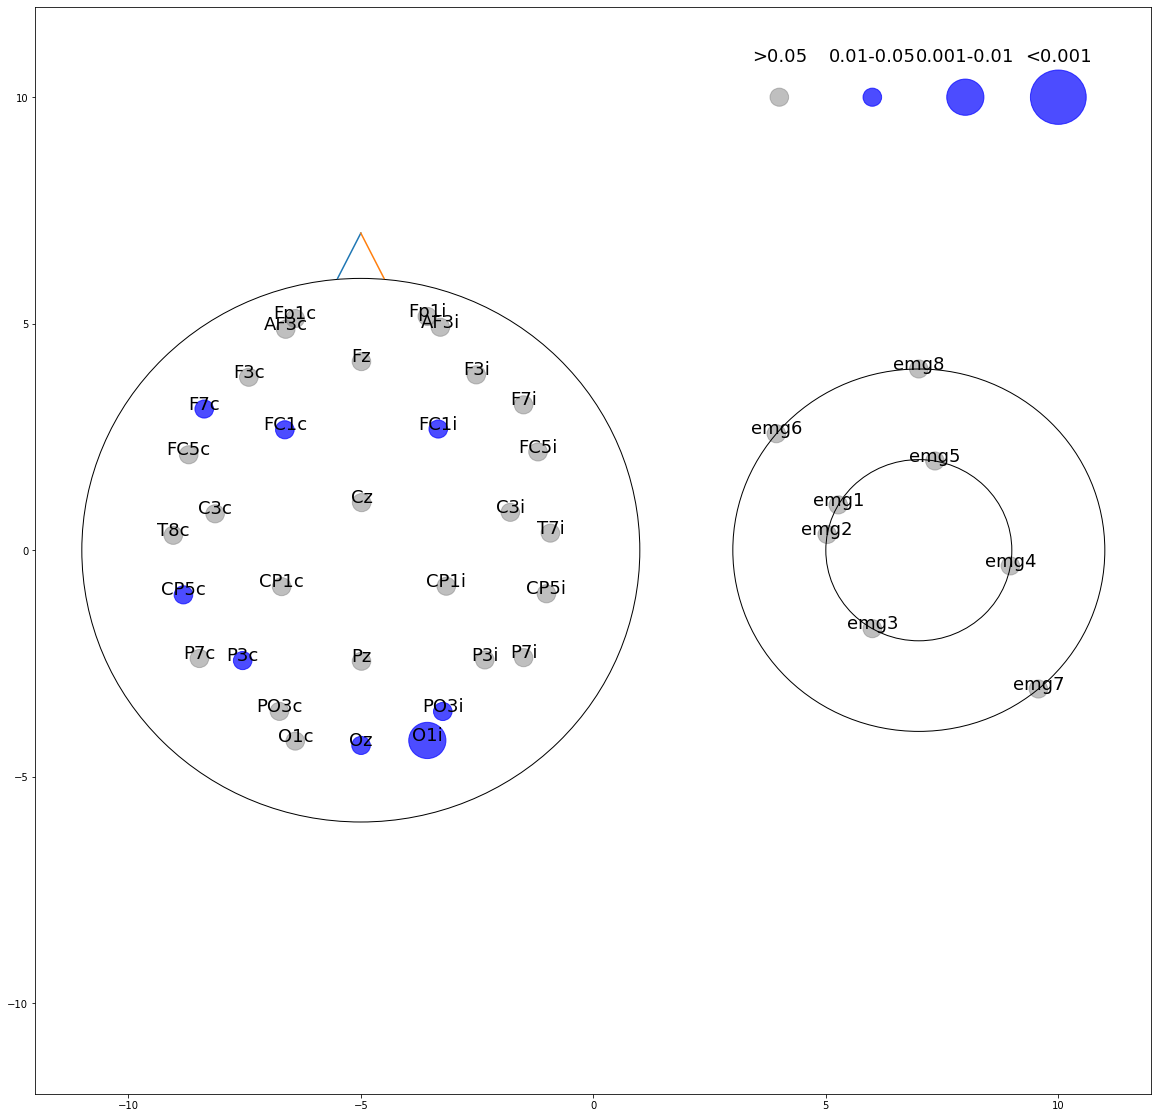

In [5]:
#visualisation
pvalue_levels = [0.05,0.01,0.001]
def radiusBasedOnP (pvalue, defaultR=0.2):
    radius = None
    for level_idx in range(len(pvalue_levels)):
        if pvalue <= pvalue_levels[level_idx]:
            if radius == None:
                radius = defaultR
            else: 
                radius += defaultR
        else:
            return radius
    return radius


fig,ax = plt.subplots(figsize=(20, 20))
ax = plt.gca()
# EEG
center=[-5,0]
radius=6
circle = plt.Circle((center[0],center[1]),radius,fill = False)
ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.add_artist(circle)
#EEG_chs
for EEG in EEGs:
    radius = radiusBasedOnP(p_cost_ecc_weight[EEG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EEG.name, xy=(center[0]+EEG.x, center[1]+EEG.y), fontsize=18, color ='black', ha="center")

#EMG
center=[7,0]
for i in range(2):
    circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
    ax.add_artist(circle)
#EMG_chs
for EMG in EMGs:
    radius = radiusBasedOnP(p_cost_ecc_weight[EMG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EMG.name, xy=(center[0]+EMG.x, center[1]+EMG.y), fontsize=18, color ='black', ha="center")
    
plt.xlim(-12,12)
plt.ylim(-12,12)


circle = plt.Circle((4,10), radius=0.2,fill = True, color = 'grey',alpha=0.5)
ax.add_patch(circle)
ax.annotate('>'+str(pvalue_levels[0]), xy=(4,10.8), fontsize=18, color ='black', ha="center")
increment = 0
for pvalue_level in pvalue_levels[1:]:
    increment+=1
    circle = plt.Circle((4+increment*2,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(str(pvalue_levels[increment])+'-'+str(pvalue_levels[increment-1]),
                xy=(4+increment*2,10.8), fontsize=18, color ='black', ha="center")
    
increment+=1    
circle = plt.Circle((4+2*increment,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
ax.add_patch(circle)
ax.annotate('<'+str(pvalue_levels[-1]), xy=(4+2*increment,10.8), 
            fontsize=18, color ='black', ha="center")

# save fig
# fName = os.path.join(preVsPostTMS_results_dir,'cost_ecc_weight_topo.eps')
# plt.savefig(fName)

## eigenvector C

In [20]:
p_eigenvectorC = {key:None for key in chs_list_image}
list_gProperties =['Fp1i_eigenvector_centrality', 'AF3i_eigenvector_centrality', 'F3i_eigenvector_centrality',
                   'F7i_eigenvector_centrality', 'FC1i_eigenvector_centrality', 'FC5i_eigenvector_centrality',
                   'C3i_eigenvector_centrality', 'T7i_eigenvector_centrality', 'CP1i_eigenvector_centrality',
                   'CP5i_eigenvector_centrality', 'P3i_eigenvector_centrality', 'P7i_eigenvector_centrality',
                   'PO3i_eigenvector_centrality', 'O1i_eigenvector_centrality', 'Fz_eigenvector_centrality',
                   'Cz_eigenvector_centrality', 'Pz_eigenvector_centrality', 'Oz_eigenvector_centrality',
                   'Fp1c_eigenvector_centrality', 'AF3c_eigenvector_centrality', 'F3c_eigenvector_centrality', 
                   'F7c_eigenvector_centrality', 'FC1c_eigenvector_centrality', 'FC5c_eigenvector_centrality', 
                   'C3c_eigenvector_centrality', 'T8c_eigenvector_centrality', 'CP1c_eigenvector_centrality', 
                   'CP5c_eigenvector_centrality', 'P3c_eigenvector_centrality', 'P7c_eigenvector_centrality',
                   'PO3c_eigenvector_centrality', 'O1c_eigenvector_centrality','emg1_eigenvector_centrality',
                   'emg2_eigenvector_centrality','emg3_eigenvector_centrality','emg4_eigenvector_centrality',
                   'emg5_eigenvector_centrality','emg6_eigenvector_centrality','emg7_eigenvector_centrality',
                   'emg8_eigenvector_centrality'] 
for gProperty in list_gProperties:    
    t_stat,pvalue = scipy.stats.ttest_ind((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                          (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty], equal_var=False)
    cohen_s_d = round(cohend((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                 (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty]),2)
    p_eigenvectorC[gProperty.split('_')[0]]=pvalue
    print(gProperty + ": pvalue = {}, cohen's d = {}, t_stat = {}".format(round(pvalue,2),cohen_s_d,round(t_stat,2)))


Fp1i_eigenvector_centrality: pvalue = 0.6, cohen's d = -0.34, t_stat = -0.54
AF3i_eigenvector_centrality: pvalue = 0.15, cohen's d = 1.03, t_stat = 1.63
F3i_eigenvector_centrality: pvalue = 0.29, cohen's d = 0.73, t_stat = 1.15
F7i_eigenvector_centrality: pvalue = 0.5, cohen's d = 0.45, t_stat = 0.71
FC1i_eigenvector_centrality: pvalue = 0.96, cohen's d = 0.03, t_stat = 0.05
FC5i_eigenvector_centrality: pvalue = 0.65, cohen's d = 0.3, t_stat = 0.47
C3i_eigenvector_centrality: pvalue = 0.41, cohen's d = -0.57, t_stat = -0.9
T7i_eigenvector_centrality: pvalue = 0.22, cohen's d = 0.84, t_stat = 1.33
CP1i_eigenvector_centrality: pvalue = 0.17, cohen's d = 0.99, t_stat = 1.56
CP5i_eigenvector_centrality: pvalue = 0.79, cohen's d = -0.18, t_stat = -0.29
P3i_eigenvector_centrality: pvalue = 0.65, cohen's d = 0.3, t_stat = 0.47
P7i_eigenvector_centrality: pvalue = 0.27, cohen's d = -0.75, t_stat = -1.19
PO3i_eigenvector_centrality: pvalue = 0.76, cohen's d = -0.2, t_stat = -0.32
O1i_eigenvecto

Text(10, 10.8, '<0.05')

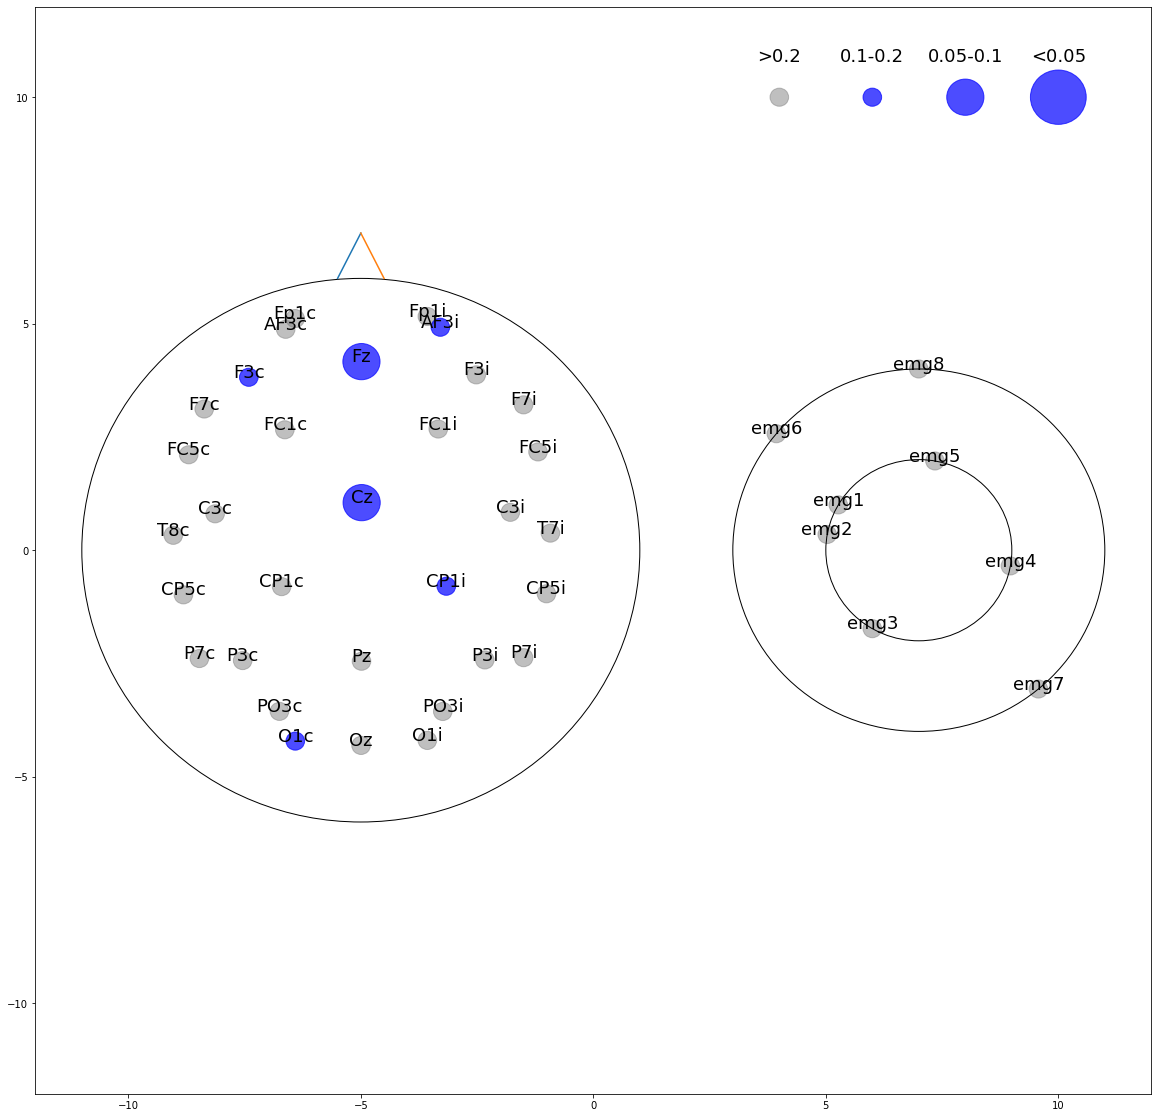

In [23]:
#visualisation
pvalue_levels = [0.2,0.1,0.05]
def radiusBasedOnP (pvalue, defaultR=0.2):
    radius = None
    for level_idx in range(len(pvalue_levels)):
        if pvalue <= pvalue_levels[level_idx]:
            if radius == None:
                radius = defaultR
            else: 
                radius += defaultR
        else:
            return radius
    return radius


fig,ax = plt.subplots(figsize=(20, 20))
ax = plt.gca()
# EEG
center=[-5,0]
radius=6
circle = plt.Circle((center[0],center[1]),radius,fill = False)
ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.add_artist(circle)
#EEG_chs
for EEG in EEGs:
    radius = radiusBasedOnP(p_eigenvectorC[EEG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EEG.name, xy=(center[0]+EEG.x, center[1]+EEG.y), fontsize=18, color ='black', ha="center")

#EMG
center=[7,0]
for i in range(2):
    circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
    ax.add_artist(circle)
#EMG_chs
for EMG in EMGs:
    radius = radiusBasedOnP(p_eigenvectorC[EMG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EMG.name, xy=(center[0]+EMG.x, center[1]+EMG.y), fontsize=18, color ='black', ha="center")
    
plt.xlim(-12,12)
plt.ylim(-12,12)


circle = plt.Circle((4,10), radius=0.2,fill = True, color = 'grey',alpha=0.5)
ax.add_patch(circle)
ax.annotate('>'+str(pvalue_levels[0]), xy=(4,10.8), fontsize=18, color ='black', ha="center")
increment = 0
for pvalue_level in pvalue_levels[1:]:
    increment+=1
    circle = plt.Circle((4+increment*2,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(str(pvalue_levels[increment])+'-'+str(pvalue_levels[increment-1]),
                xy=(4+increment*2,10.8), fontsize=18, color ='black', ha="center")
    
increment+=1    
circle = plt.Circle((4+2*increment,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
ax.add_patch(circle)
ax.annotate('<'+str(pvalue_levels[-1]), xy=(4+2*increment,10.8), 
            fontsize=18, color ='black', ha="center")

# save fig
# fName = os.path.join(strokeVsHealthy_results_dir,'betweenness_centrality_topo.eps')
# plt.savefig(fName)

## betweennessC

In [24]:
p_betweennessC = {key:None for key in chs_list_image}
list_gProperties =['Fp1i_betweenness_centrality', 'AF3i_betweenness_centrality', 'F3i_betweenness_centrality',
                   'F7i_betweenness_centrality', 'FC1i_betweenness_centrality', 'FC5i_betweenness_centrality',
                   'C3i_betweenness_centrality', 'T7i_betweenness_centrality', 'CP1i_betweenness_centrality',
                   'CP5i_betweenness_centrality', 'P3i_betweenness_centrality', 'P7i_betweenness_centrality',
                   'PO3i_betweenness_centrality', 'O1i_betweenness_centrality', 'Fz_betweenness_centrality',
                   'Cz_betweenness_centrality', 'Pz_betweenness_centrality', 'Oz_betweenness_centrality',
                   'Fp1c_betweenness_centrality', 'AF3c_betweenness_centrality', 'F3c_betweenness_centrality', 
                   'F7c_betweenness_centrality', 'FC1c_betweenness_centrality', 'FC5c_betweenness_centrality', 
                   'C3c_betweenness_centrality', 'T8c_betweenness_centrality', 'CP1c_betweenness_centrality', 
                   'CP5c_betweenness_centrality', 'P3c_betweenness_centrality', 'P7c_betweenness_centrality',
                   'PO3c_betweenness_centrality', 'O1c_betweenness_centrality','emg1_betweenness_centrality',
                   'emg2_betweenness_centrality','emg3_betweenness_centrality','emg4_betweenness_centrality',
                   'emg5_betweenness_centrality','emg6_betweenness_centrality','emg7_betweenness_centrality',
                   'emg8_betweenness_centrality'] 
for gProperty in list_gProperties:    
    t_stat,pvalue = scipy.stats.ttest_ind((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                          (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty], equal_var=False)
    cohen_s_d = round(cohend((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                 (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty]),2)
    p_betweennessC[gProperty.split('_')[0]]=pvalue
    print(gProperty + ": pvalue = {}, cohen's d = {}, t_stat = {}".format(round(pvalue,2),cohen_s_d,round(t_stat,2)))
    

Fp1i_betweenness_centrality: pvalue = 0.29, cohen's d = -0.77, t_stat = -1.22
AF3i_betweenness_centrality: pvalue = 0.36, cohen's d = 0.64, t_stat = 1.01
F3i_betweenness_centrality: pvalue = 0.44, cohen's d = 0.54, t_stat = 0.86
F7i_betweenness_centrality: pvalue = 0.38, cohen's d = 0.61, t_stat = 0.97
FC1i_betweenness_centrality: pvalue = 0.91, cohen's d = -0.08, t_stat = -0.12
FC5i_betweenness_centrality: pvalue = 0.85, cohen's d = 0.12, t_stat = 0.19
C3i_betweenness_centrality: pvalue = 0.17, cohen's d = -1.03, t_stat = -1.63
T7i_betweenness_centrality: pvalue = 0.85, cohen's d = -0.13, t_stat = -0.2
CP1i_betweenness_centrality: pvalue = 0.43, cohen's d = 0.53, t_stat = 0.84
CP5i_betweenness_centrality: pvalue = 0.71, cohen's d = -0.24, t_stat = -0.39
P3i_betweenness_centrality: pvalue = 0.35, cohen's d = 0.65, t_stat = 1.03
P7i_betweenness_centrality: pvalue = 0.38, cohen's d = -0.62, t_stat = -0.98
PO3i_betweenness_centrality: pvalue = 0.52, cohen's d = -0.45, t_stat = -0.71
O1i_b

Text(10, 10.8, '<0.05')

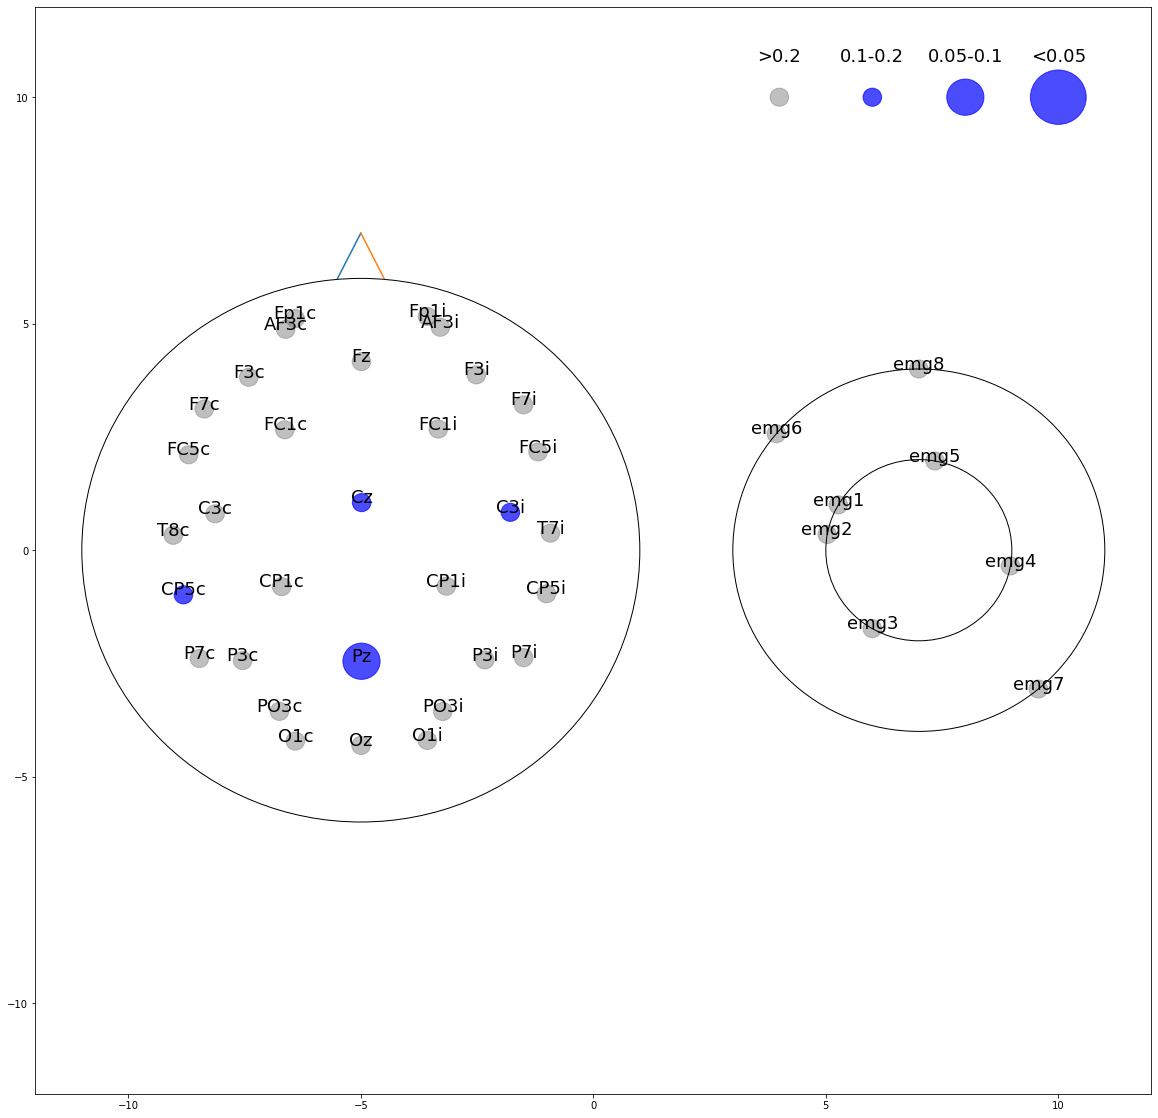

In [25]:
#visualisation
pvalue_levels = [0.2,0.1,0.05]
def radiusBasedOnP (pvalue, defaultR=0.2):
    radius = None
    for level_idx in range(len(pvalue_levels)):
        if pvalue <= pvalue_levels[level_idx]:
            if radius == None:
                radius = defaultR
            else: 
                radius += defaultR
        else:
            return radius
    return radius


fig,ax = plt.subplots(figsize=(20, 20))
ax = plt.gca()
# EEG
center=[-5,0]
radius=6
circle = plt.Circle((center[0],center[1]),radius,fill = False)
ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.add_artist(circle)
#EEG_chs
for EEG in EEGs:
    radius = radiusBasedOnP(p_betweennessC[EEG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EEG.name, xy=(center[0]+EEG.x, center[1]+EEG.y), fontsize=18, color ='black', ha="center")

#EMG
center=[7,0]
for i in range(2):
    circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
    ax.add_artist(circle)
#EMG_chs
for EMG in EMGs:
    radius = radiusBasedOnP(p_betweennessC[EMG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EMG.name, xy=(center[0]+EMG.x, center[1]+EMG.y), fontsize=18, color ='black', ha="center")
    
plt.xlim(-12,12)
plt.ylim(-12,12)


circle = plt.Circle((4,10), radius=0.2,fill = True, color = 'grey',alpha=0.5)
ax.add_patch(circle)
ax.annotate('>'+str(pvalue_levels[0]), xy=(4,10.8), fontsize=18, color ='black', ha="center")
increment = 0
for pvalue_level in pvalue_levels[1:]:
    increment+=1
    circle = plt.Circle((4+increment*2,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(str(pvalue_levels[increment])+'-'+str(pvalue_levels[increment-1]),
                xy=(4+increment*2,10.8), fontsize=18, color ='black', ha="center")
    
increment+=1    
circle = plt.Circle((4+2*increment,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
ax.add_patch(circle)
ax.annotate('<'+str(pvalue_levels[-1]), xy=(4+2*increment,10.8), 
            fontsize=18, color ='black', ha="center")

# save fig
# fName = os.path.join(strokeVsHealthy_results_dir,'betweenness_centrality_topo.eps')
# plt.savefig(fName)

## closenessC

In [26]:
p_closenessC = {key:None for key in chs_list_image}
list_gProperties =['Fp1i_closeness_centrality', 'AF3i_closeness_centrality', 'F3i_closeness_centrality',
                   'F7i_closeness_centrality', 'FC1i_closeness_centrality', 'FC5i_closeness_centrality',
                   'C3i_closeness_centrality', 'T7i_closeness_centrality', 'CP1i_closeness_centrality',
                   'CP5i_closeness_centrality', 'P3i_closeness_centrality', 'P7i_closeness_centrality',
                   'PO3i_closeness_centrality', 'O1i_closeness_centrality', 'Fz_closeness_centrality',
                   'Cz_closeness_centrality', 'Pz_closeness_centrality', 'Oz_closeness_centrality',
                   'Fp1c_closeness_centrality', 'AF3c_closeness_centrality', 'F3c_closeness_centrality', 
                   'F7c_closeness_centrality', 'FC1c_closeness_centrality', 'FC5c_closeness_centrality', 
                   'C3c_closeness_centrality', 'T8c_closeness_centrality', 'CP1c_closeness_centrality', 
                   'CP5c_closeness_centrality', 'P3c_closeness_centrality', 'P7c_closeness_centrality',
                   'PO3c_closeness_centrality', 'O1c_closeness_centrality','emg1_closeness_centrality',
                   'emg2_closeness_centrality','emg3_closeness_centrality','emg4_closeness_centrality',
                   'emg5_closeness_centrality','emg6_closeness_centrality','emg7_closeness_centrality',
                   'emg8_closeness_centrality'] 
for gProperty in list_gProperties:    
    t_stat,pvalue = scipy.stats.ttest_ind((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                          (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty], equal_var=False)
    cohen_s_d = round(cohend((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                 (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty]),2)
    p_closenessC[gProperty.split('_')[0]]=pvalue
    print(gProperty + ": pvalue = {}, cohen's d = {}, t_stat = {}".format(round(pvalue,2),cohen_s_d,round(t_stat,2)))
    

Fp1i_closeness_centrality: pvalue = 0.67, cohen's d = -0.29, t_stat = -0.45
AF3i_closeness_centrality: pvalue = 0.75, cohen's d = 0.22, t_stat = 0.34
F3i_closeness_centrality: pvalue = 0.61, cohen's d = 0.34, t_stat = 0.53
F7i_closeness_centrality: pvalue = 0.61, cohen's d = 0.34, t_stat = 0.54
FC1i_closeness_centrality: pvalue = 0.52, cohen's d = 0.44, t_stat = 0.7
FC5i_closeness_centrality: pvalue = 0.41, cohen's d = 0.56, t_stat = 0.88
C3i_closeness_centrality: pvalue = 0.66, cohen's d = -0.3, t_stat = -0.47
T7i_closeness_centrality: pvalue = 0.68, cohen's d = 0.27, t_stat = 0.43
CP1i_closeness_centrality: pvalue = 0.44, cohen's d = 0.52, t_stat = 0.82
CP5i_closeness_centrality: pvalue = 0.59, cohen's d = -0.36, t_stat = -0.56
P3i_closeness_centrality: pvalue = 0.97, cohen's d = -0.02, t_stat = -0.04
P7i_closeness_centrality: pvalue = 0.32, cohen's d = -0.7, t_stat = -1.1
PO3i_closeness_centrality: pvalue = 0.96, cohen's d = -0.03, t_stat = -0.05
O1i_closeness_centrality: pvalue = 0

Text(10, 10.8, '<0.05')

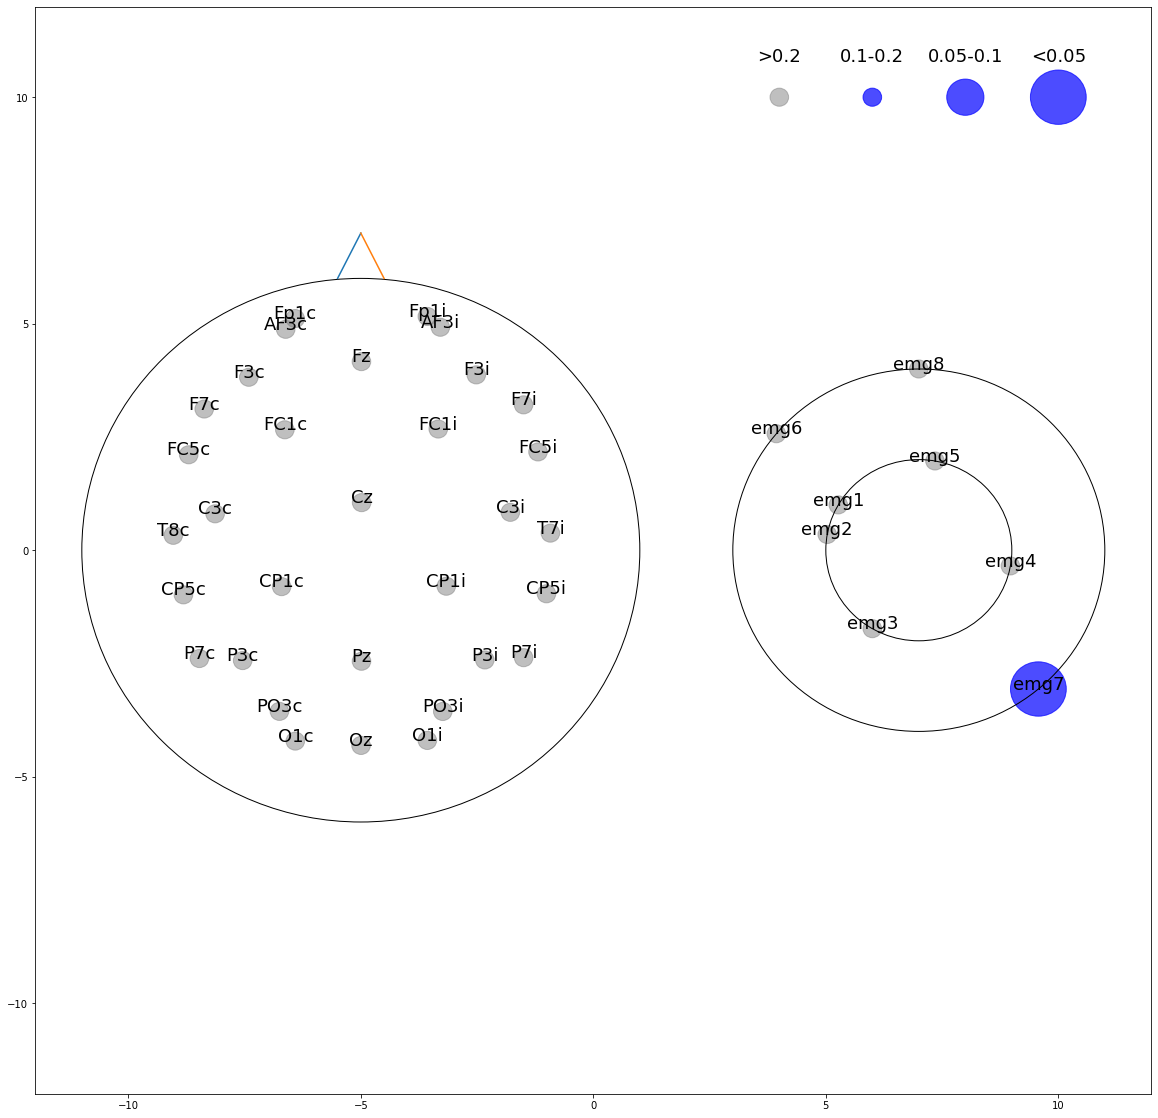

In [27]:
#visualisation
pvalue_levels = [0.2,0.1,0.05]
def radiusBasedOnP (pvalue, defaultR=0.2):
    radius = None
    for level_idx in range(len(pvalue_levels)):
        if pvalue <= pvalue_levels[level_idx]:
            if radius == None:
                radius = defaultR
            else: 
                radius += defaultR
        else:
            return radius
    return radius


fig,ax = plt.subplots(figsize=(20, 20))
ax = plt.gca()
# EEG
center=[-5,0]
radius=6
circle = plt.Circle((center[0],center[1]),radius,fill = False)
ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.add_artist(circle)
#EEG_chs
for EEG in EEGs:
    radius = radiusBasedOnP(p_closenessC[EEG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EEG.name, xy=(center[0]+EEG.x, center[1]+EEG.y), fontsize=18, color ='black', ha="center")

#EMG
center=[7,0]
for i in range(2):
    circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
    ax.add_artist(circle)
#EMG_chs
for EMG in EMGs:
    radius = radiusBasedOnP(p_closenessC[EMG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EMG.name, xy=(center[0]+EMG.x, center[1]+EMG.y), fontsize=18, color ='black', ha="center")
    
plt.xlim(-12,12)
plt.ylim(-12,12)


circle = plt.Circle((4,10), radius=0.2,fill = True, color = 'grey',alpha=0.5)
ax.add_patch(circle)
ax.annotate('>'+str(pvalue_levels[0]), xy=(4,10.8), fontsize=18, color ='black', ha="center")
increment = 0
for pvalue_level in pvalue_levels[1:]:
    increment+=1
    circle = plt.Circle((4+increment*2,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(str(pvalue_levels[increment])+'-'+str(pvalue_levels[increment-1]),
                xy=(4+increment*2,10.8), fontsize=18, color ='black', ha="center")
    
increment+=1    
circle = plt.Circle((4+2*increment,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
ax.add_patch(circle)
ax.annotate('<'+str(pvalue_levels[-1]), xy=(4+2*increment,10.8), 
            fontsize=18, color ='black', ha="center")

# save fig
# fName = os.path.join(strokeVsHealthy_results_dir,'betweenness_centrality_topo.eps')
# plt.savefig(fName)

## cost_betweennessC

In [28]:
p_cost_betweennessC = {key:None for key in chs_list_image}
list_gProperties =['Fp1i_cost_betweenness_centrality', 'AF3i_cost_betweenness_centrality', 'F3i_cost_betweenness_centrality',
                   'F7i_cost_betweenness_centrality', 'FC1i_cost_betweenness_centrality', 'FC5i_cost_betweenness_centrality',
                   'C3i_cost_betweenness_centrality', 'T7i_cost_betweenness_centrality', 'CP1i_cost_betweenness_centrality',
                   'CP5i_cost_betweenness_centrality', 'P3i_cost_betweenness_centrality', 'P7i_cost_betweenness_centrality',
                   'PO3i_cost_betweenness_centrality', 'O1i_cost_betweenness_centrality', 'Fz_cost_betweenness_centrality',
                   'Cz_cost_betweenness_centrality', 'Pz_cost_betweenness_centrality', 'Oz_cost_betweenness_centrality',
                   'Fp1c_cost_betweenness_centrality', 'AF3c_cost_betweenness_centrality', 'F3c_cost_betweenness_centrality', 
                   'F7c_cost_betweenness_centrality', 'FC1c_cost_betweenness_centrality', 'FC5c_cost_betweenness_centrality', 
                   'C3c_cost_betweenness_centrality', 'T8c_cost_betweenness_centrality', 'CP1c_cost_betweenness_centrality', 
                   'CP5c_cost_betweenness_centrality', 'P3c_cost_betweenness_centrality', 'P7c_cost_betweenness_centrality',
                   'PO3c_cost_betweenness_centrality', 'O1c_cost_betweenness_centrality','emg1_cost_betweenness_centrality',
                   'emg2_cost_betweenness_centrality','emg3_cost_betweenness_centrality','emg4_cost_betweenness_centrality',
                   'emg5_cost_betweenness_centrality','emg6_cost_betweenness_centrality','emg7_cost_betweenness_centrality',
                   'emg8_cost_betweenness_centrality'] 
for gProperty in list_gProperties:    
    t_stat,pvalue = scipy.stats.ttest_ind((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                          (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty], equal_var=False)
    cohen_s_d = round(cohend((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                 (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty]),2)
    p_cost_betweennessC[gProperty.split('_')[0]]=pvalue
    print(gProperty + ": pvalue = {}, cohen's d = {}, t_stat = {}".format(round(pvalue,2),cohen_s_d,round(t_stat,2)))
    

Fp1i_cost_betweenness_centrality: pvalue = 0.2, cohen's d = -0.93, t_stat = -1.48
AF3i_cost_betweenness_centrality: pvalue = 0.3, cohen's d = -0.74, t_stat = -1.18
F3i_cost_betweenness_centrality: pvalue = 0.25, cohen's d = 0.85, t_stat = 1.35
F7i_cost_betweenness_centrality: pvalue = 0.3, cohen's d = 0.71, t_stat = 1.12
FC1i_cost_betweenness_centrality: pvalue = 0.34, cohen's d = 0.68, t_stat = 1.08
FC5i_cost_betweenness_centrality: pvalue = 0.7, cohen's d = -0.26, t_stat = -0.41
C3i_cost_betweenness_centrality: pvalue = 0.54, cohen's d = 0.42, t_stat = 0.66
T7i_cost_betweenness_centrality: pvalue = 0.98, cohen's d = -0.02, t_stat = -0.03
CP1i_cost_betweenness_centrality: pvalue = 0.25, cohen's d = -0.86, t_stat = -1.35
CP5i_cost_betweenness_centrality: pvalue = 0.2, cohen's d = -0.95, t_stat = -1.51
P3i_cost_betweenness_centrality: pvalue = 0.35, cohen's d = 0.66, t_stat = 1.04
P7i_cost_betweenness_centrality: pvalue = 0.67, cohen's d = -0.28, t_stat = -0.45
PO3i_cost_betweenness_cen

d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


Text(10, 10.8, '<0.05')

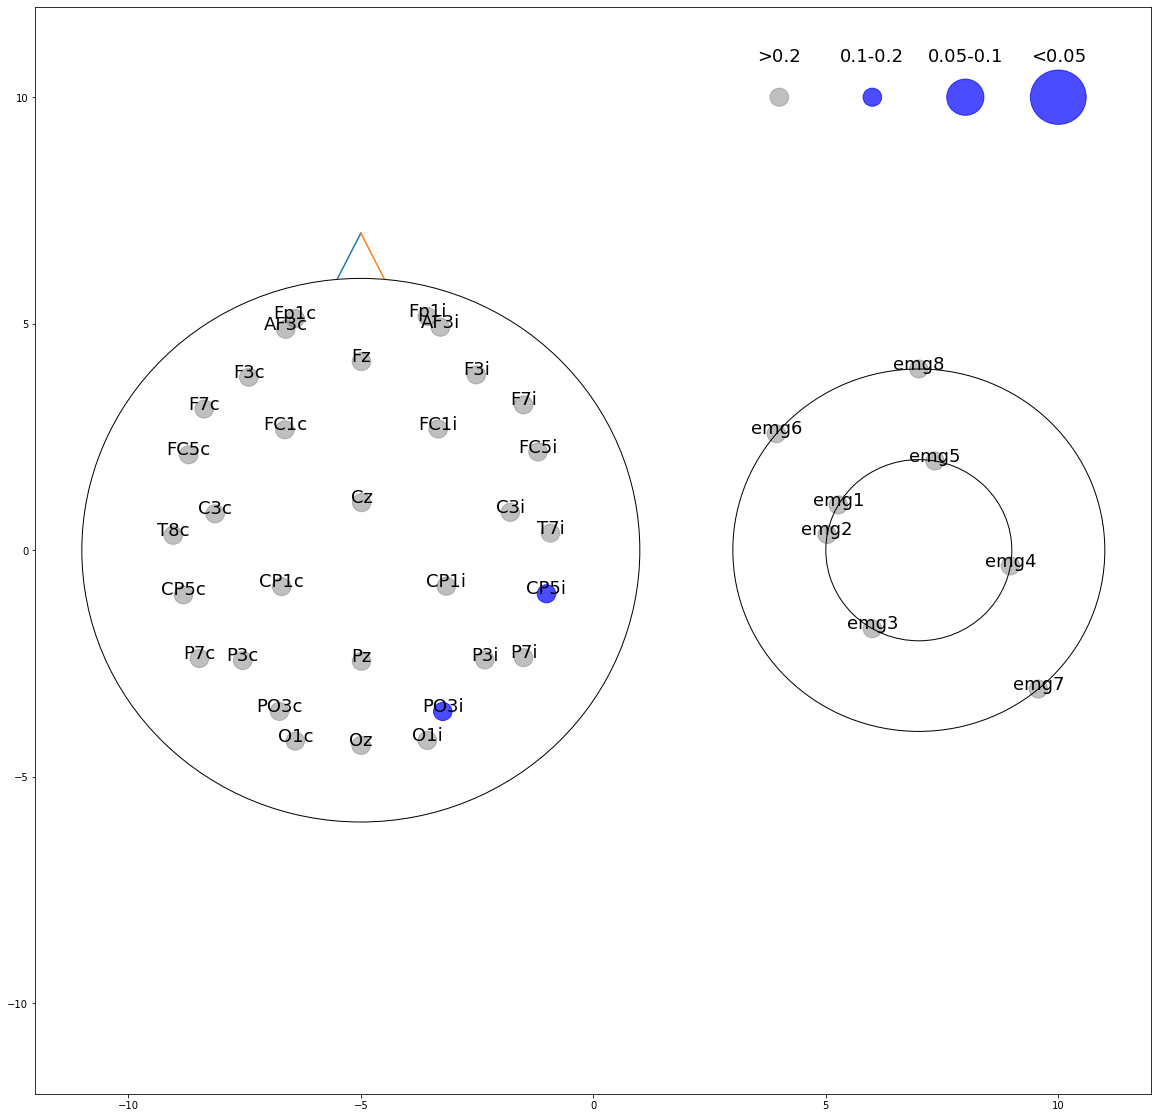

In [29]:
#visualisation
pvalue_levels = [0.2,0.1,0.05]
def radiusBasedOnP (pvalue, defaultR=0.2):
    radius = None
    for level_idx in range(len(pvalue_levels)):
        if pvalue <= pvalue_levels[level_idx]:
            if radius == None:
                radius = defaultR
            else: 
                radius += defaultR
        else:
            return radius
    return radius


fig,ax = plt.subplots(figsize=(20, 20))
ax = plt.gca()
# EEG
center=[-5,0]
radius=6
circle = plt.Circle((center[0],center[1]),radius,fill = False)
ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.add_artist(circle)
#EEG_chs
for EEG in EEGs:
    radius = radiusBasedOnP(p_cost_betweennessC[EEG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EEG.name, xy=(center[0]+EEG.x, center[1]+EEG.y), fontsize=18, color ='black', ha="center")

#EMG
center=[7,0]
for i in range(2):
    circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
    ax.add_artist(circle)
#EMG_chs
for EMG in EMGs:
    radius = radiusBasedOnP(p_cost_betweennessC[EMG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EMG.name, xy=(center[0]+EMG.x, center[1]+EMG.y), fontsize=18, color ='black', ha="center")
    
plt.xlim(-12,12)
plt.ylim(-12,12)


circle = plt.Circle((4,10), radius=0.2,fill = True, color = 'grey',alpha=0.5)
ax.add_patch(circle)
ax.annotate('>'+str(pvalue_levels[0]), xy=(4,10.8), fontsize=18, color ='black', ha="center")
increment = 0
for pvalue_level in pvalue_levels[1:]:
    increment+=1
    circle = plt.Circle((4+increment*2,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(str(pvalue_levels[increment])+'-'+str(pvalue_levels[increment-1]),
                xy=(4+increment*2,10.8), fontsize=18, color ='black', ha="center")
    
increment+=1    
circle = plt.Circle((4+2*increment,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
ax.add_patch(circle)
ax.annotate('<'+str(pvalue_levels[-1]), xy=(4+2*increment,10.8), 
            fontsize=18, color ='black', ha="center")

# save fig
# fName = os.path.join(strokeVsHealthy_results_dir,'cost_betweenness_centrality_topo.eps')
# plt.savefig(fName)

## cost_closenessC

In [30]:
p_cost_closenessC = {key:None for key in chs_list_image}
list_gProperties =['Fp1i_cost_closeness_centrality', 'AF3i_cost_closeness_centrality', 'F3i_cost_closeness_centrality',
                   'F7i_cost_closeness_centrality', 'FC1i_cost_closeness_centrality', 'FC5i_cost_closeness_centrality',
                   'C3i_cost_closeness_centrality', 'T7i_cost_closeness_centrality', 'CP1i_cost_closeness_centrality',
                   'CP5i_cost_closeness_centrality', 'P3i_cost_closeness_centrality', 'P7i_cost_closeness_centrality',
                   'PO3i_cost_closeness_centrality', 'O1i_cost_closeness_centrality', 'Fz_cost_closeness_centrality',
                   'Cz_cost_closeness_centrality', 'Pz_cost_closeness_centrality', 'Oz_cost_closeness_centrality',
                   'Fp1c_cost_closeness_centrality', 'AF3c_cost_closeness_centrality', 'F3c_cost_closeness_centrality', 
                   'F7c_cost_closeness_centrality', 'FC1c_cost_closeness_centrality', 'FC5c_cost_closeness_centrality', 
                   'C3c_cost_closeness_centrality', 'T8c_cost_closeness_centrality', 'CP1c_cost_closeness_centrality', 
                   'CP5c_cost_closeness_centrality', 'P3c_cost_closeness_centrality', 'P7c_cost_closeness_centrality',
                   'PO3c_cost_closeness_centrality', 'O1c_cost_closeness_centrality','emg1_cost_closeness_centrality',
                   'emg2_cost_closeness_centrality','emg3_cost_closeness_centrality','emg4_cost_closeness_centrality',
                   'emg5_cost_closeness_centrality','emg6_cost_closeness_centrality','emg7_cost_closeness_centrality',
                   'emg8_cost_closeness_centrality'] 
for gProperty in list_gProperties:    
    t_stat,pvalue = scipy.stats.ttest_ind((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                          (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty], equal_var=False)
    cohen_s_d = round(cohend((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                 (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty]),2)
    p_cost_closenessC[gProperty.split('_')[0]]=pvalue
    print(gProperty + ": pvalue = {}, cohen's d = {}, t_stat = {}".format(round(pvalue,2),cohen_s_d,round(t_stat,2)))
    

Fp1i_cost_closeness_centrality: pvalue = 0.77, cohen's d = -0.2, t_stat = -0.31
AF3i_cost_closeness_centrality: pvalue = 0.73, cohen's d = 0.22, t_stat = 0.35
F3i_cost_closeness_centrality: pvalue = 0.48, cohen's d = 0.47, t_stat = 0.74
F7i_cost_closeness_centrality: pvalue = 0.68, cohen's d = 0.27, t_stat = 0.42
FC1i_cost_closeness_centrality: pvalue = 0.54, cohen's d = 0.4, t_stat = 0.64
FC5i_cost_closeness_centrality: pvalue = 0.31, cohen's d = 0.7, t_stat = 1.1
C3i_cost_closeness_centrality: pvalue = 0.42, cohen's d = 0.54, t_stat = 0.85
T7i_cost_closeness_centrality: pvalue = 0.74, cohen's d = 0.22, t_stat = 0.34
CP1i_cost_closeness_centrality: pvalue = 0.55, cohen's d = 0.4, t_stat = 0.63
CP5i_cost_closeness_centrality: pvalue = 0.67, cohen's d = 0.28, t_stat = 0.44
P3i_cost_closeness_centrality: pvalue = 0.62, cohen's d = 0.33, t_stat = 0.52
P7i_cost_closeness_centrality: pvalue = 0.61, cohen's d = 0.34, t_stat = 0.54
PO3i_cost_closeness_centrality: pvalue = 0.53, cohen's d = 0.

Text(10, 10.8, '<0.05')

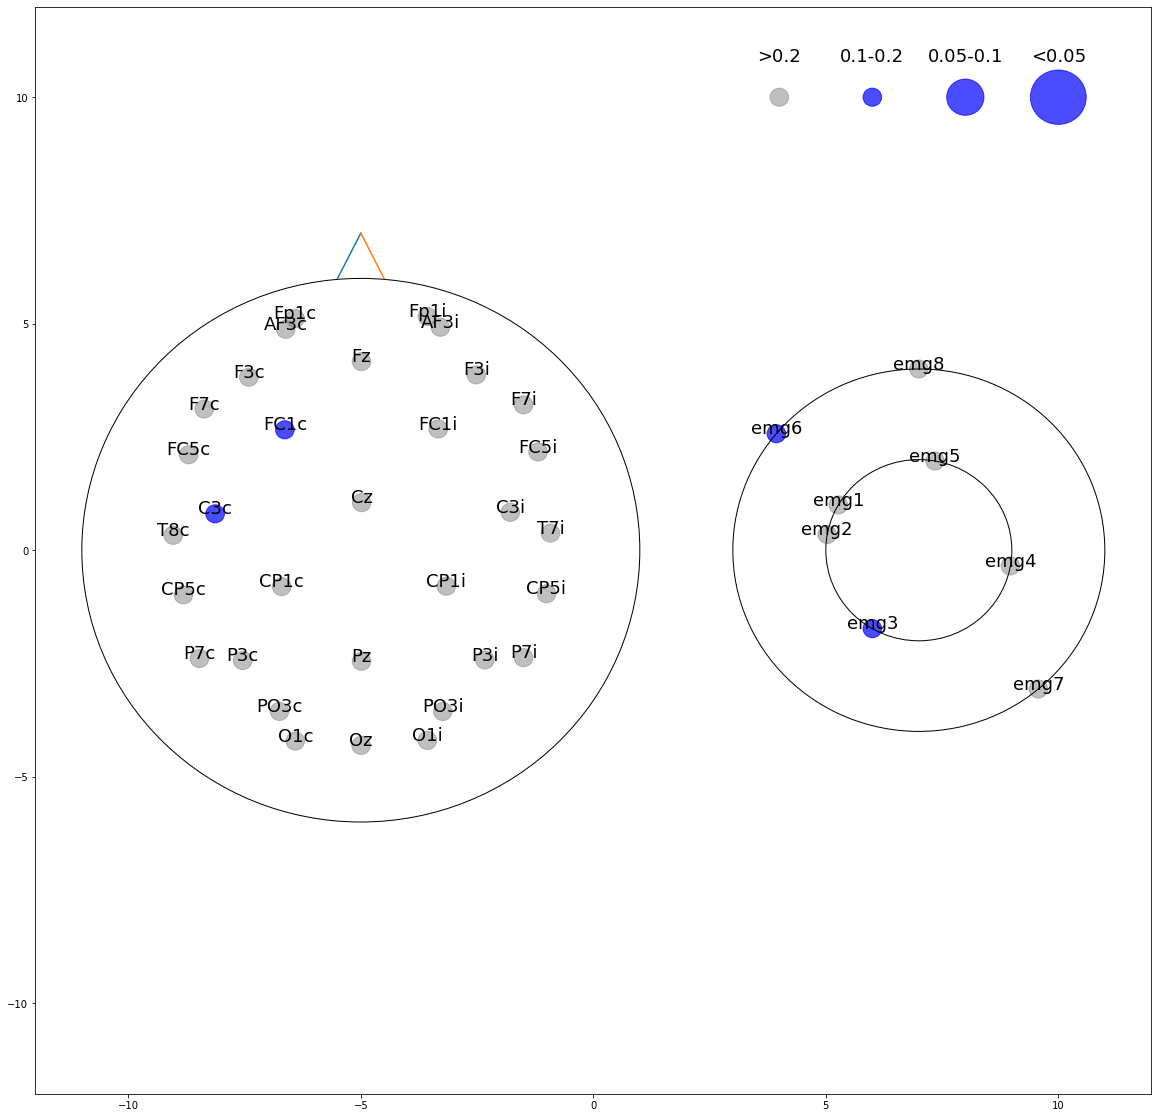

In [31]:
#visualisation
pvalue_levels = [0.2,0.1,0.05]
def radiusBasedOnP (pvalue, defaultR=0.2):
    radius = None
    for level_idx in range(len(pvalue_levels)):
        if pvalue <= pvalue_levels[level_idx]:
            if radius == None:
                radius = defaultR
            else: 
                radius += defaultR
        else:
            return radius
    return radius


fig,ax = plt.subplots(figsize=(20, 20))
ax = plt.gca()
# EEG
center=[-5,0]
radius=6
circle = plt.Circle((center[0],center[1]),radius,fill = False)
ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.add_artist(circle)
#EEG_chs
for EEG in EEGs:
    radius = radiusBasedOnP(p_cost_closenessC[EEG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EEG.name, xy=(center[0]+EEG.x, center[1]+EEG.y), fontsize=18, color ='black', ha="center")

#EMG
center=[7,0]
for i in range(2):
    circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
    ax.add_artist(circle)
#EMG_chs
for EMG in EMGs:
    radius = radiusBasedOnP(p_cost_closenessC[EMG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EMG.name, xy=(center[0]+EMG.x, center[1]+EMG.y), fontsize=18, color ='black', ha="center")
    
plt.xlim(-12,12)
plt.ylim(-12,12)


circle = plt.Circle((4,10), radius=0.2,fill = True, color = 'grey',alpha=0.5)
ax.add_patch(circle)
ax.annotate('>'+str(pvalue_levels[0]), xy=(4,10.8), fontsize=18, color ='black', ha="center")
increment = 0
for pvalue_level in pvalue_levels[1:]:
    increment+=1
    circle = plt.Circle((4+increment*2,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(str(pvalue_levels[increment])+'-'+str(pvalue_levels[increment-1]),
                xy=(4+increment*2,10.8), fontsize=18, color ='black', ha="center")
    
increment+=1    
circle = plt.Circle((4+2*increment,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
ax.add_patch(circle)
ax.annotate('<'+str(pvalue_levels[-1]), xy=(4+2*increment,10.8), 
            fontsize=18, color ='black', ha="center")

# save fig
# fName = os.path.join(strokeVsHealthy_results_dir,'betweenness_centrality_topo.eps')
# plt.savefig(fName)

## cost_eigenVC

In [32]:
p_cost_eigenvectorC = {key:None for key in chs_list_image}
list_gProperties =['Fp1i_cost_eigenvector_centrality', 'AF3i_cost_eigenvector_centrality', 'F3i_cost_eigenvector_centrality',
                   'F7i_cost_eigenvector_centrality', 'FC1i_cost_eigenvector_centrality', 'FC5i_cost_eigenvector_centrality',
                   'C3i_cost_eigenvector_centrality', 'T7i_cost_eigenvector_centrality', 'CP1i_cost_eigenvector_centrality',
                   'CP5i_cost_eigenvector_centrality', 'P3i_cost_eigenvector_centrality', 'P7i_cost_eigenvector_centrality',
                   'PO3i_cost_eigenvector_centrality', 'O1i_cost_eigenvector_centrality', 'Fz_cost_eigenvector_centrality',
                   'Cz_cost_eigenvector_centrality', 'Pz_cost_eigenvector_centrality', 'Oz_cost_eigenvector_centrality',
                   'Fp1c_cost_eigenvector_centrality', 'AF3c_cost_eigenvector_centrality', 'F3c_cost_eigenvector_centrality', 
                   'F7c_cost_eigenvector_centrality', 'FC1c_cost_eigenvector_centrality', 'FC5c_cost_eigenvector_centrality', 
                   'C3c_cost_eigenvector_centrality', 'T8c_cost_eigenvector_centrality', 'CP1c_cost_eigenvector_centrality', 
                   'CP5c_cost_eigenvector_centrality', 'P3c_cost_eigenvector_centrality', 'P7c_cost_eigenvector_centrality',
                   'PO3c_cost_eigenvector_centrality', 'O1c_cost_eigenvector_centrality','emg1_cost_eigenvector_centrality',
                   'emg2_cost_eigenvector_centrality','emg3_cost_eigenvector_centrality','emg4_cost_eigenvector_centrality',
                   'emg5_cost_eigenvector_centrality','emg6_cost_eigenvector_centrality','emg7_cost_eigenvector_centrality',
                   'emg8_cost_eigenvector_centrality'] 
for gProperty in list_gProperties:    
    t_stat,pvalue = scipy.stats.ttest_ind((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                          (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty], equal_var=False)
    cohen_s_d = round(cohend((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                 (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty]),2)
    p_cost_eigenvectorC[gProperty.split('_')[0]]=pvalue
    print(gProperty + ": pvalue = {}, cohen's d = {}, t_stat = {}".format(round(pvalue,2),cohen_s_d,round(t_stat,2)))
    

Fp1i_cost_eigenvector_centrality: pvalue = 0.6, cohen's d = -0.34, t_stat = -0.54
AF3i_cost_eigenvector_centrality: pvalue = 0.15, cohen's d = 1.03, t_stat = 1.63
F3i_cost_eigenvector_centrality: pvalue = 0.29, cohen's d = 0.73, t_stat = 1.15
F7i_cost_eigenvector_centrality: pvalue = 0.5, cohen's d = 0.45, t_stat = 0.71
FC1i_cost_eigenvector_centrality: pvalue = 0.96, cohen's d = 0.03, t_stat = 0.05
FC5i_cost_eigenvector_centrality: pvalue = 0.65, cohen's d = 0.3, t_stat = 0.47
C3i_cost_eigenvector_centrality: pvalue = 0.41, cohen's d = -0.57, t_stat = -0.9
T7i_cost_eigenvector_centrality: pvalue = 0.22, cohen's d = 0.84, t_stat = 1.33
CP1i_cost_eigenvector_centrality: pvalue = 0.17, cohen's d = 0.99, t_stat = 1.56
CP5i_cost_eigenvector_centrality: pvalue = 0.79, cohen's d = -0.18, t_stat = -0.29
P3i_cost_eigenvector_centrality: pvalue = 0.65, cohen's d = 0.3, t_stat = 0.47
P7i_cost_eigenvector_centrality: pvalue = 0.27, cohen's d = -0.75, t_stat = -1.19
PO3i_cost_eigenvector_centralit

Text(10, 10.8, '<0.05')

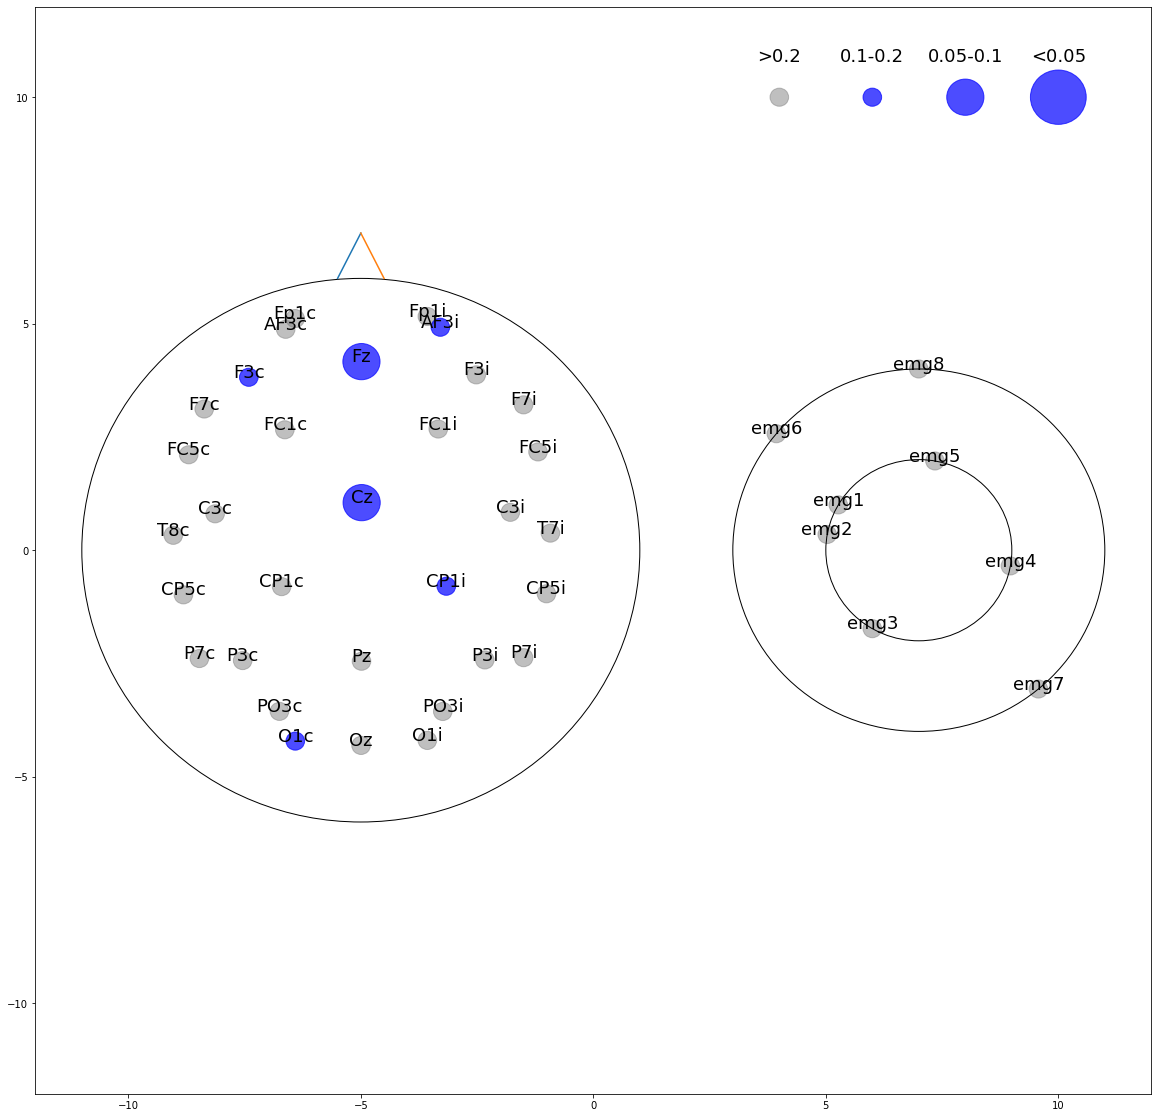

In [33]:
#visualisation
pvalue_levels = [0.2,0.1,0.05]
def radiusBasedOnP (pvalue, defaultR=0.2):
    radius = None
    for level_idx in range(len(pvalue_levels)):
        if pvalue <= pvalue_levels[level_idx]:
            if radius == None:
                radius = defaultR
            else: 
                radius += defaultR
        else:
            return radius
    return radius


fig,ax = plt.subplots(figsize=(20, 20))
ax = plt.gca()
# EEG
center=[-5,0]
radius=6
circle = plt.Circle((center[0],center[1]),radius,fill = False)
ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.add_artist(circle)
#EEG_chs
for EEG in EEGs:
    radius = radiusBasedOnP(p_cost_eigenvectorC[EEG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EEG.name, xy=(center[0]+EEG.x, center[1]+EEG.y), fontsize=18, color ='black', ha="center")

#EMG
center=[7,0]
for i in range(2):
    circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
    ax.add_artist(circle)
#EMG_chs
for EMG in EMGs:
    radius = radiusBasedOnP(p_cost_eigenvectorC[EMG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EMG.name, xy=(center[0]+EMG.x, center[1]+EMG.y), fontsize=18, color ='black', ha="center")
    
plt.xlim(-12,12)
plt.ylim(-12,12)


circle = plt.Circle((4,10), radius=0.2,fill = True, color = 'grey',alpha=0.5)
ax.add_patch(circle)
ax.annotate('>'+str(pvalue_levels[0]), xy=(4,10.8), fontsize=18, color ='black', ha="center")
increment = 0
for pvalue_level in pvalue_levels[1:]:
    increment+=1
    circle = plt.Circle((4+increment*2,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(str(pvalue_levels[increment])+'-'+str(pvalue_levels[increment-1]),
                xy=(4+increment*2,10.8), fontsize=18, color ='black', ha="center")
    
increment+=1    
circle = plt.Circle((4+2*increment,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
ax.add_patch(circle)
ax.annotate('<'+str(pvalue_levels[-1]), xy=(4+2*increment,10.8), 
            fontsize=18, color ='black', ha="center")

# save fig
# fName = os.path.join(strokeVsHealthy_results_dir,'betweenness_centrality_topo.eps')
# plt.savefig(fName)

## clusteringC_weight

In [34]:
p_clusteringC_weight = {key:None for key in chs_list_image}
list_gProperties =['Fp1i_clusteringC_weight', 'AF3i_clusteringC_weight', 'F3i_clusteringC_weight',
                   'F7i_clusteringC_weight', 'FC1i_clusteringC_weight', 'FC5i_clusteringC_weight',
                   'C3i_clusteringC_weight', 'T7i_clusteringC_weight', 'CP1i_clusteringC_weight',
                   'CP5i_clusteringC_weight', 'P3i_clusteringC_weight', 'P7i_clusteringC_weight',
                   'PO3i_clusteringC_weight', 'O1i_clusteringC_weight', 'Fz_clusteringC_weight',
                   'Cz_clusteringC_weight', 'Pz_clusteringC_weight', 'Oz_clusteringC_weight',
                   'Fp1c_clusteringC_weight', 'AF3c_clusteringC_weight', 'F3c_clusteringC_weight', 
                   'F7c_clusteringC_weight', 'FC1c_clusteringC_weight', 'FC5c_clusteringC_weight', 
                   'C3c_clusteringC_weight', 'T8c_clusteringC_weight', 'CP1c_clusteringC_weight', 
                   'CP5c_clusteringC_weight', 'P3c_clusteringC_weight', 'P7c_clusteringC_weight',
                   'PO3c_clusteringC_weight', 'O1c_clusteringC_weight','emg1_clusteringC_weight',
                   'emg2_clusteringC_weight','emg3_clusteringC_weight','emg4_clusteringC_weight',
                   'emg5_clusteringC_weight','emg6_clusteringC_weight','emg7_clusteringC_weight',
                   'emg8_clusteringC_weight'] 
for gProperty in list_gProperties:    
    t_stat,pvalue = scipy.stats.ttest_ind((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                          (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty], equal_var=False)
    cohen_s_d = round(cohend((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                 (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty]),2)
    p_clusteringC_weight[gProperty.split('_')[0]]=pvalue
    print(gProperty + ": pvalue = {}, cohen's d = {}, t_stat = {}".format(round(pvalue,2),cohen_s_d,round(t_stat,2)))
    

Fp1i_clusteringC_weight: pvalue = 0.91, cohen's d = -0.07, t_stat = -0.12
AF3i_clusteringC_weight: pvalue = 0.75, cohen's d = -0.21, t_stat = -0.33
F3i_clusteringC_weight: pvalue = 0.96, cohen's d = 0.03, t_stat = 0.05
F7i_clusteringC_weight: pvalue = 0.8, cohen's d = -0.17, t_stat = -0.27
FC1i_clusteringC_weight: pvalue = 0.71, cohen's d = 0.24, t_stat = 0.39
FC5i_clusteringC_weight: pvalue = 0.96, cohen's d = 0.04, t_stat = 0.06
C3i_clusteringC_weight: pvalue = 0.72, cohen's d = 0.24, t_stat = 0.37
T7i_clusteringC_weight: pvalue = 0.73, cohen's d = -0.23, t_stat = -0.36
CP1i_clusteringC_weight: pvalue = 0.8, cohen's d = 0.17, t_stat = 0.27
CP5i_clusteringC_weight: pvalue = 0.92, cohen's d = 0.06, t_stat = 0.1
P3i_clusteringC_weight: pvalue = 0.89, cohen's d = 0.09, t_stat = 0.15
P7i_clusteringC_weight: pvalue = 0.75, cohen's d = 0.21, t_stat = 0.33
PO3i_clusteringC_weight: pvalue = 0.72, cohen's d = 0.23, t_stat = 0.37
O1i_clusteringC_weight: pvalue = 0.59, cohen's d = 0.35, t_stat =

Text(10, 10.8, '<0.05')

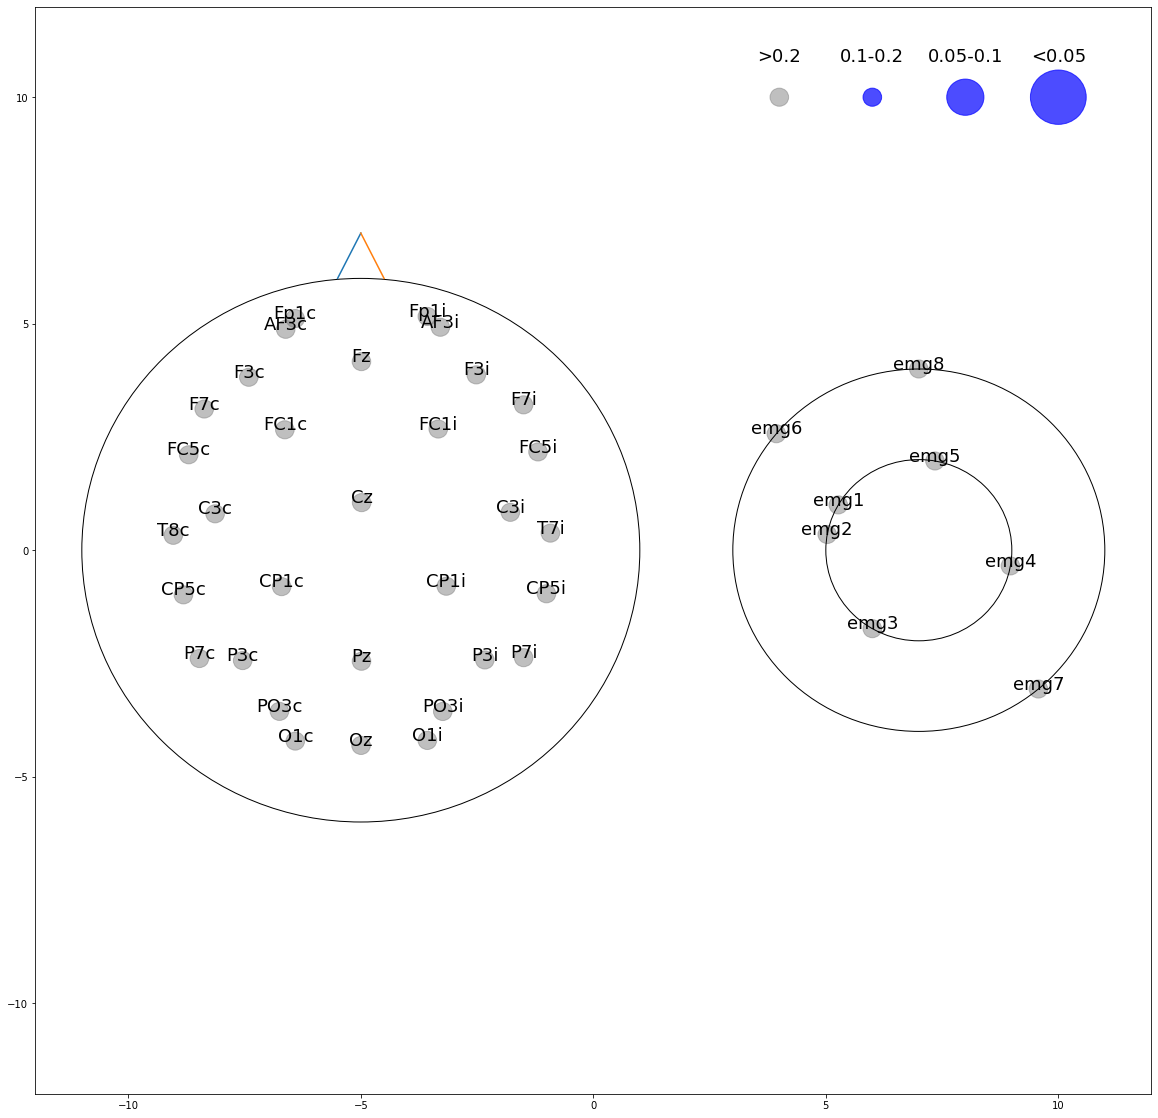

In [35]:
#visualisation

#redefinition
EMGs=[EMGChannel(2,150,'emg1'),EMGChannel(2,170,'emg2'),EMGChannel(2, 240,'emg3'),EMGChannel(2,350,'emg4'),
      EMGChannel(2, 80,'emg5'),EMGChannel(4,140,'emg6'),EMGChannel(4, 310,'emg7'),
      EMGChannel(4,90,'emg8')]

EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][0]*50,
           y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][1]*50,
           name=ch) for ch in chs_list_image[:32]] 

pvalue_levels = [0.2,0.1,0.05]
def radiusBasedOnP (pvalue, defaultR=0.2):
    radius = None
    for level_idx in range(len(pvalue_levels)):
        if pvalue <= pvalue_levels[level_idx]:
            if radius == None:
                radius = defaultR
            else: 
                radius += defaultR
        else:
            return radius
    return radius


fig,ax = plt.subplots(figsize=(20, 20))
ax = plt.gca()
# EEG
center=[-5,0]
radius=6
circle = plt.Circle((center[0],center[1]),radius,fill = False)
ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.add_artist(circle)
#EEG_chs
for EEG in EEGs:
    radius = radiusBasedOnP(p_clusteringC_weight[EEG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EEG.name, xy=(center[0]+EEG.x, center[1]+EEG.y), fontsize=18, color ='black', ha="center")

#EMG
center=[7,0]
for i in range(2):
    circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
    ax.add_artist(circle)
#EMG_chs
for EMG in EMGs:
    radius = radiusBasedOnP(p_clusteringC_weight[EMG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EMG.name, xy=(center[0]+EMG.x, center[1]+EMG.y), fontsize=18, color ='black', ha="center")
    
plt.xlim(-12,12)
plt.ylim(-12,12)


circle = plt.Circle((4,10), radius=0.2,fill = True, color = 'grey',alpha=0.5)
ax.add_patch(circle)
ax.annotate('>'+str(pvalue_levels[0]), xy=(4,10.8), fontsize=18, color ='black', ha="center")
increment = 0
for pvalue_level in pvalue_levels[1:]:
    increment+=1
    circle = plt.Circle((4+increment*2,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(str(pvalue_levels[increment])+'-'+str(pvalue_levels[increment-1]),
                xy=(4+increment*2,10.8), fontsize=18, color ='black', ha="center")
    
increment+=1    
circle = plt.Circle((4+2*increment,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
ax.add_patch(circle)
ax.annotate('<'+str(pvalue_levels[-1]), xy=(4+2*increment,10.8), 
            fontsize=18, color ='black', ha="center")

# save fig
# fName = os.path.join(strokeVsHealthy_results_dir,'betweenness_centrality_topo.eps')
# plt.savefig(fName)

## closenessVitality

In [36]:
p_closeness_vitality = {key:None for key in chs_list_image}
list_gProperties =['Fp1i_closeness_vitality', 'AF3i_closeness_vitality', 'F3i_closeness_vitality',
                   'F7i_closeness_vitality', 'FC1i_closeness_vitality', 'FC5i_closeness_vitality',
                   'C3i_closeness_vitality', 'T7i_closeness_vitality', 'CP1i_closeness_vitality',
                   'CP5i_closeness_vitality', 'P3i_closeness_vitality', 'P7i_closeness_vitality',
                   'PO3i_closeness_vitality', 'O1i_closeness_vitality', 'Fz_closeness_vitality',
                   'Cz_closeness_vitality', 'Pz_closeness_vitality', 'Oz_closeness_vitality',
                   'Fp1c_closeness_vitality', 'AF3c_closeness_vitality', 'F3c_closeness_vitality', 
                   'F7c_closeness_vitality', 'FC1c_closeness_vitality', 'FC5c_closeness_vitality', 
                   'C3c_closeness_vitality', 'T8c_closeness_vitality', 'CP1c_closeness_vitality', 
                   'CP5c_closeness_vitality', 'P3c_closeness_vitality', 'P7c_closeness_vitality',
                   'PO3c_closeness_vitality', 'O1c_closeness_vitality','emg1_closeness_vitality',
                   'emg2_closeness_vitality','emg3_closeness_vitality','emg4_closeness_vitality',
                   'emg5_closeness_vitality','emg6_closeness_vitality','emg7_closeness_vitality',
                   'emg8_closeness_vitality'] 
for gProperty in list_gProperties:    
    t_stat,pvalue = scipy.stats.ttest_ind((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                          (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty], equal_var=False)
    cohen_s_d = round(cohend((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                 (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty]),2)
    p_closeness_vitality[gProperty.split('_')[0]]=pvalue
    print(gProperty + ": pvalue = {}, cohen's d = {}, t_stat = {}".format(round(pvalue,2),cohen_s_d,round(t_stat,2)))
    

Fp1i_closeness_vitality: pvalue = 0.71, cohen's d = 0.24, t_stat = 0.38
AF3i_closeness_vitality: pvalue = 0.89, cohen's d = 0.09, t_stat = 0.14
F3i_closeness_vitality: pvalue = 0.69, cohen's d = 0.26, t_stat = 0.41
F7i_closeness_vitality: pvalue = 0.27, cohen's d = 0.76, t_stat = 1.2
FC1i_closeness_vitality: pvalue = 0.73, cohen's d = 0.23, t_stat = 0.37
FC5i_closeness_vitality: pvalue = 0.89, cohen's d = -0.09, t_stat = -0.14
C3i_closeness_vitality: pvalue = 0.53, cohen's d = 0.42, t_stat = 0.67
T7i_closeness_vitality: pvalue = 0.29, cohen's d = -0.75, t_stat = -1.19
CP1i_closeness_vitality: pvalue = 0.42, cohen's d = -0.55, t_stat = -0.87
CP5i_closeness_vitality: pvalue = 0.86, cohen's d = -0.11, t_stat = -0.18
P3i_closeness_vitality: pvalue = 0.2, cohen's d = -0.96, t_stat = -1.53
P7i_closeness_vitality: pvalue = 0.5, cohen's d = -0.47, t_stat = -0.74
PO3i_closeness_vitality: pvalue = 0.4, cohen's d = -0.59, t_stat = -0.93
O1i_closeness_vitality: pvalue = 0.74, cohen's d = -0.22, t_

Text(10, 10.8, '<0.05')

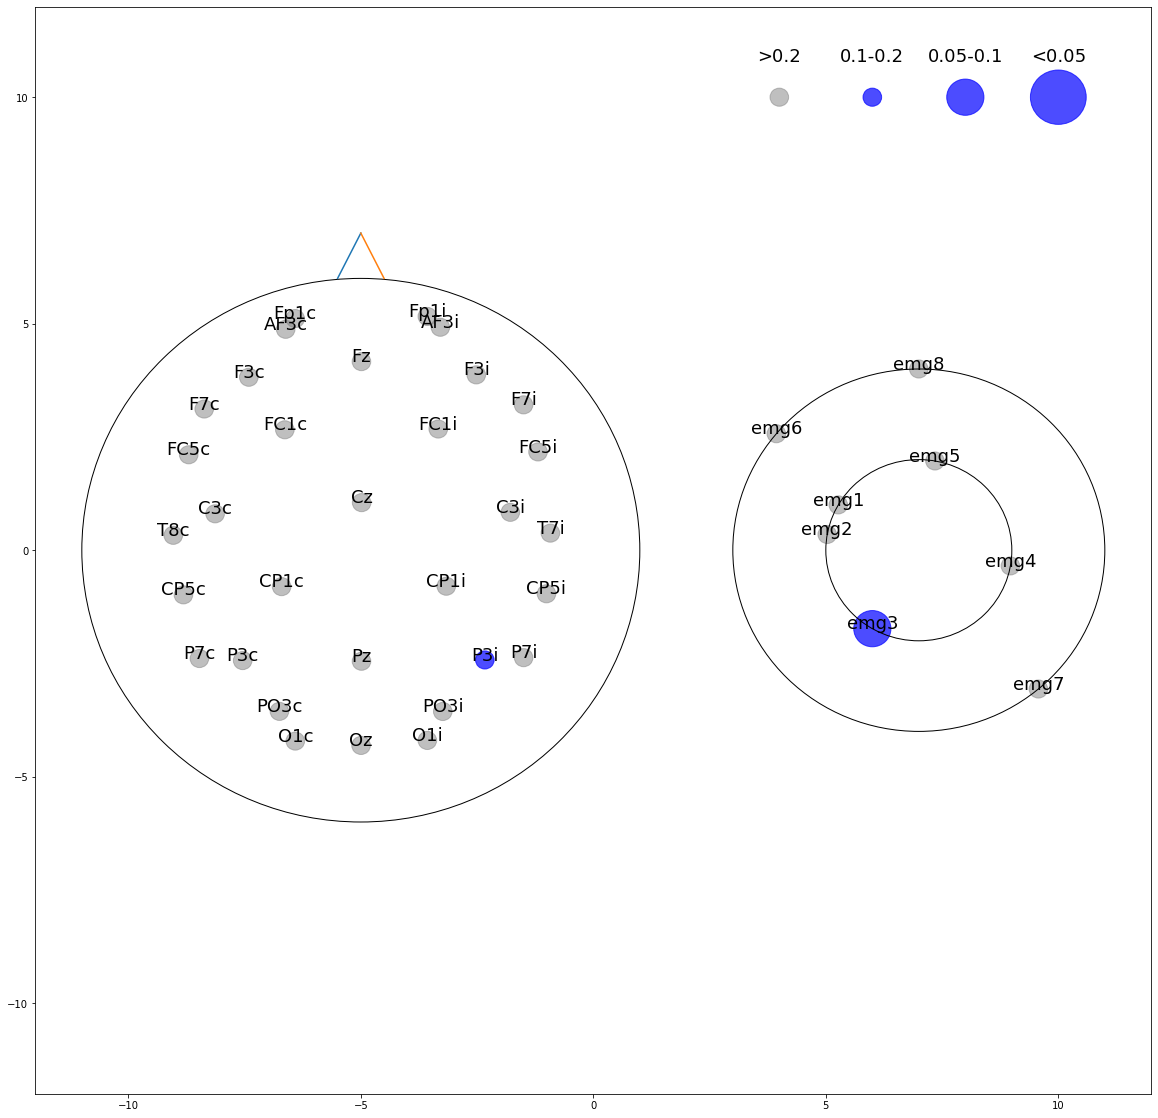

In [37]:
#visualisation
pvalue_levels = [0.2,0.1,0.05]
def radiusBasedOnP (pvalue, defaultR=0.2):
    radius = None
    for level_idx in range(len(pvalue_levels)):
        if pvalue <= pvalue_levels[level_idx]:
            if radius == None:
                radius = defaultR
            else: 
                radius += defaultR
        else:
            return radius
    return radius


fig,ax = plt.subplots(figsize=(20, 20))
ax = plt.gca()
# EEG
center=[-5,0]
radius=6
circle = plt.Circle((center[0],center[1]),radius,fill = False)
ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.add_artist(circle)
#EEG_chs
for EEG in EEGs:
    radius = radiusBasedOnP(p_closeness_vitality[EEG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EEG.name, xy=(center[0]+EEG.x, center[1]+EEG.y), fontsize=18, color ='black', ha="center")

#EMG
center=[7,0]
for i in range(2):
    circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
    ax.add_artist(circle)
#EMG_chs
for EMG in EMGs:
    radius = radiusBasedOnP(p_closeness_vitality[EMG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EMG.name, xy=(center[0]+EMG.x, center[1]+EMG.y), fontsize=18, color ='black', ha="center")
    
plt.xlim(-12,12)
plt.ylim(-12,12)


circle = plt.Circle((4,10), radius=0.2,fill = True, color = 'grey',alpha=0.5)
ax.add_patch(circle)
ax.annotate('>'+str(pvalue_levels[0]), xy=(4,10.8), fontsize=18, color ='black', ha="center")
increment = 0
for pvalue_level in pvalue_levels[1:]:
    increment+=1
    circle = plt.Circle((4+increment*2,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(str(pvalue_levels[increment])+'-'+str(pvalue_levels[increment-1]),
                xy=(4+increment*2,10.8), fontsize=18, color ='black', ha="center")
    
increment+=1    
circle = plt.Circle((4+2*increment,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
ax.add_patch(circle)
ax.annotate('<'+str(pvalue_levels[-1]), xy=(4+2*increment,10.8), 
            fontsize=18, color ='black', ha="center")

# save fig
# fName = os.path.join(strokeVsHealthy_results_dir,'betweenness_centrality_topo.eps')
# plt.savefig(fName)

## closenessVitality_weight

In [38]:
p_closeness_vitality_weight = {key:None for key in chs_list_image}
list_gProperties =['Fp1i_closeness_vitality_weight', 'AF3i_closeness_vitality_weight', 'F3i_closeness_vitality_weight',
                   'F7i_closeness_vitality_weight', 'FC1i_closeness_vitality_weight', 'FC5i_closeness_vitality_weight',
                   'C3i_closeness_vitality_weight', 'T7i_closeness_vitality_weight', 'CP1i_closeness_vitality_weight',
                   'CP5i_closeness_vitality_weight', 'P3i_closeness_vitality', 'P7i_closeness_vitality_weight',
                   'PO3i_closeness_vitality_weight', 'O1i_closeness_vitality', 'Fz_closeness_vitality_weight',
                   'Cz_closeness_vitality_weight', 'Pz_closeness_vitality_weight', 'Oz_closeness_vitality_weight',
                   'Fp1c_closeness_vitality_weight', 'AF3c_closeness_vitality_weight', 'F3c_closeness_vitality_weight', 
                   'F7c_closeness_vitality_weight', 'FC1c_closeness_vitality_weight', 'FC5c_closeness_vitality_weight', 
                   'C3c_closeness_vitality_weight', 'T8c_closeness_vitality_weight', 'CP1c_closeness_vitality_weight', 
                   'CP5c_closeness_vitality_weight', 'P3c_closeness_vitality_weight', 'P7c_closeness_vitality_weight',
                   'PO3c_closeness_vitality_weight', 'O1c_closeness_vitality_weight','emg1_closeness_vitality_weight',
                   'emg2_closeness_vitality_weight','emg3_closeness_vitality_weight','emg4_closeness_vitality_weight',
                   'emg5_closeness_vitality_weight','emg6_closeness_vitality_weight','emg7_closeness_vitality_weight',
                   'emg8_closeness_vitality_weight'] 
for gProperty in list_gProperties:    
    t_stat,pvalue = scipy.stats.ttest_ind((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                          (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty], equal_var=False)
    cohen_s_d = round(cohend((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                 (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty]),2)
    p_closeness_vitality_weight[gProperty.split('_')[0]]=pvalue
    print(gProperty + ": pvalue = {}, cohen's d = {}, t_stat = {}".format(round(pvalue,2),cohen_s_d,round(t_stat,2)))
    

Fp1i_closeness_vitality_weight: pvalue = 0.31, cohen's d = 0.69, t_stat = 1.09
AF3i_closeness_vitality_weight: pvalue = 0.99, cohen's d = -0.01, t_stat = -0.02
F3i_closeness_vitality_weight: pvalue = 0.63, cohen's d = -0.32, t_stat = -0.5
F7i_closeness_vitality_weight: pvalue = 0.75, cohen's d = -0.21, t_stat = -0.33
FC1i_closeness_vitality_weight: pvalue = 0.71, cohen's d = -0.25, t_stat = -0.39
FC5i_closeness_vitality_weight: pvalue = 0.6, cohen's d = -0.35, t_stat = -0.55
C3i_closeness_vitality_weight: pvalue = 0.35, cohen's d = 0.66, t_stat = 1.04
T7i_closeness_vitality_weight: pvalue = 0.78, cohen's d = -0.18, t_stat = -0.28
CP1i_closeness_vitality_weight: pvalue = 0.44, cohen's d = -0.52, t_stat = -0.81
CP5i_closeness_vitality_weight: pvalue = 0.45, cohen's d = 0.5, t_stat = 0.79
P3i_closeness_vitality: pvalue = 0.2, cohen's d = -0.96, t_stat = -1.53
P7i_closeness_vitality_weight: pvalue = 0.38, cohen's d = 0.61, t_stat = 0.96
PO3i_closeness_vitality_weight: pvalue = 0.81, cohen'

Text(10, 10.8, '<0.05')

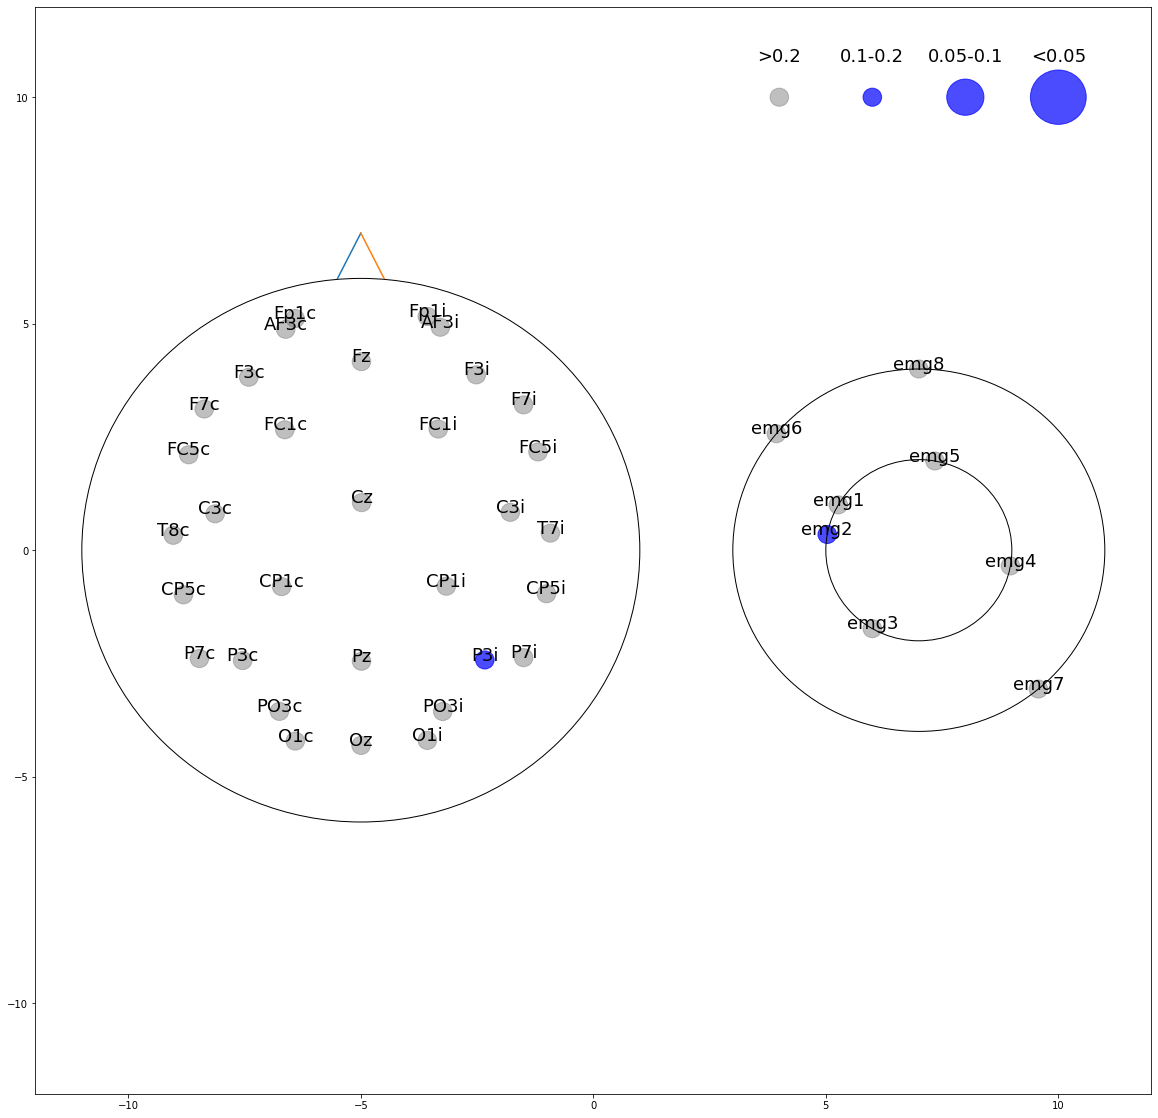

In [39]:
#visualisation
pvalue_levels = [0.2,0.1,0.05]
def radiusBasedOnP (pvalue, defaultR=0.2):
    radius = None
    for level_idx in range(len(pvalue_levels)):
        if pvalue <= pvalue_levels[level_idx]:
            if radius == None:
                radius = defaultR
            else: 
                radius += defaultR
        else:
            return radius
    return radius


fig,ax = plt.subplots(figsize=(20, 20))
ax = plt.gca()
# EEG
center=[-5,0]
radius=6
circle = plt.Circle((center[0],center[1]),radius,fill = False)
ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.add_artist(circle)
#EEG_chs
for EEG in EEGs:
    radius = radiusBasedOnP(p_closeness_vitality_weight[EEG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EEG.name, xy=(center[0]+EEG.x, center[1]+EEG.y), fontsize=18, color ='black', ha="center")

#EMG
center=[7,0]
for i in range(2):
    circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
    ax.add_artist(circle)
#EMG_chs
for EMG in EMGs:
    radius = radiusBasedOnP(p_closeness_vitality_weight[EMG.name])
    if radius == None:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EMG.name, xy=(center[0]+EMG.x, center[1]+EMG.y), fontsize=18, color ='black', ha="center")
    
plt.xlim(-12,12)
plt.ylim(-12,12)


circle = plt.Circle((4,10), radius=0.2,fill = True, color = 'grey',alpha=0.5)
ax.add_patch(circle)
ax.annotate('>'+str(pvalue_levels[0]), xy=(4,10.8), fontsize=18, color ='black', ha="center")
increment = 0
for pvalue_level in pvalue_levels[1:]:
    increment+=1
    circle = plt.Circle((4+increment*2,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(str(pvalue_levels[increment])+'-'+str(pvalue_levels[increment-1]),
                xy=(4+increment*2,10.8), fontsize=18, color ='black', ha="center")
    
increment+=1    
circle = plt.Circle((4+2*increment,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
ax.add_patch(circle)
ax.annotate('<'+str(pvalue_levels[-1]), xy=(4+2*increment,10.8), 
            fontsize=18, color ='black', ha="center")

# save fig
# fName = os.path.join(strokeVsHealthy_results_dir,'betweenness_centrality_topo.eps')
# plt.savefig(fName)

## Group C

In [46]:
p_groupC = {key:None for key in chs_list_image}
list_gProperties =['ipsiH_betweennessC','ipsiH_degreeC','ipsiH_closenessC','ipsiH_cost_betweennessC',
                   'ipsiH_cost_closenessC',
                   'contraH_betweennessC','contraH_degreeC','contraH_closenessC','contraH_cost_betweennessC',
                   'contraH_cost_closenessC',
                  'forearm_betweennessC','forearm_degreeC','forearm_closenessC','forearm_cost_betweennessC',
                   'forearm_cost_closenessC',
                  'arm_betweennessC','arm_degreeC','arm_closenessC','arm_cost_betweennessC',
                   'arm_cost_closenessC',
                  'ipsiF_betweennessC','ipsiF_degreeC','ipsiF_closenessC','ipsiF_cost_betweennessC',
                   'ipsiF_cost_closenessC',
                  'ipsiMotor_betweennessC','ipsiMotor_degreeC','ipsiMotor_closenessC','ipsiMotor_cost_betweennessC',
                   'ipsiMotor_cost_closenessC',
                  'ipsiPO_betweennessC','ipsiPO_degreeC','ipsiPO_closenessC','ipsiPO_cost_betweennessC',
                   'ipsiPO_cost_closenessC',
                  'mesial_betweennessC','mesial_degreeC','mesial_closenessC','mesial_cost_betweennessC',
                   'mesial_cost_closenessC',
                  'contraF_betweennessC','contraF_degreeC','contraF_closenessC','contraF_cost_betweennessC',
                   'contraF_cost_closenessC',
                  'contraMotor_betweennessC','contraMotor_degreeC','contraMotor_closenessC',
                   'contraMotor_cost_betweennessC','contraMotor_cost_closenessC',
                  'contraPO_betweennessC','contraPO_degreeC','contraPO_closenessC','contraPO_cost_betweennessC',
                   'contraPO_cost_closenessC',] 

for gProperty in list_gProperties:    
    t_stat,pvalue = scipy.stats.ttest_ind((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                          (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty], equal_var=False)
    cohen_s_d = round(cohend((df_prePostTMS[df_prePostTMS['group']=='preTMS'])[gProperty],
                 (df_prePostTMS[df_prePostTMS['group']=='postTMS'])[gProperty]),2)
    p_groupC[gProperty]=pvalue
    print(gProperty + ": pvalue = {}, cohen's d = {}, t_stat = {}".format(round(pvalue,2),cohen_s_d,round(t_stat,2)))
    

ipsiH_betweennessC: pvalue = 0.8, cohen's d = -0.17, t_stat = -0.26
ipsiH_degreeC: pvalue = nan, cohen's d = nan, t_stat = nan
ipsiH_closenessC: pvalue = 0.92, cohen's d = -0.07, t_stat = -0.11
ipsiH_cost_betweennessC: pvalue = 0.8, cohen's d = -0.17, t_stat = -0.26
ipsiH_cost_closenessC: pvalue = 0.92, cohen's d = -0.07, t_stat = -0.11
contraH_betweennessC: pvalue = 0.25, cohen's d = 0.79, t_stat = 1.26
contraH_degreeC: pvalue = nan, cohen's d = nan, t_stat = nan
contraH_closenessC: pvalue = 0.68, cohen's d = 0.27, t_stat = 0.43
contraH_cost_betweennessC: pvalue = 0.25, cohen's d = 0.79, t_stat = 1.26
contraH_cost_closenessC: pvalue = 0.68, cohen's d = 0.27, t_stat = 0.43
forearm_betweennessC: pvalue = 0.9, cohen's d = -0.08, t_stat = -0.13
forearm_degreeC: pvalue = 0.08, cohen's d = -1.26, t_stat = -1.99
forearm_closenessC: pvalue = 0.29, cohen's d = -0.72, t_stat = -1.13
forearm_cost_betweennessC: pvalue = 0.9, cohen's d = -0.08, t_stat = -0.13
forearm_cost_closenessC: pvalue = 0.29

d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


Text(10, 10.8, '<0.05')

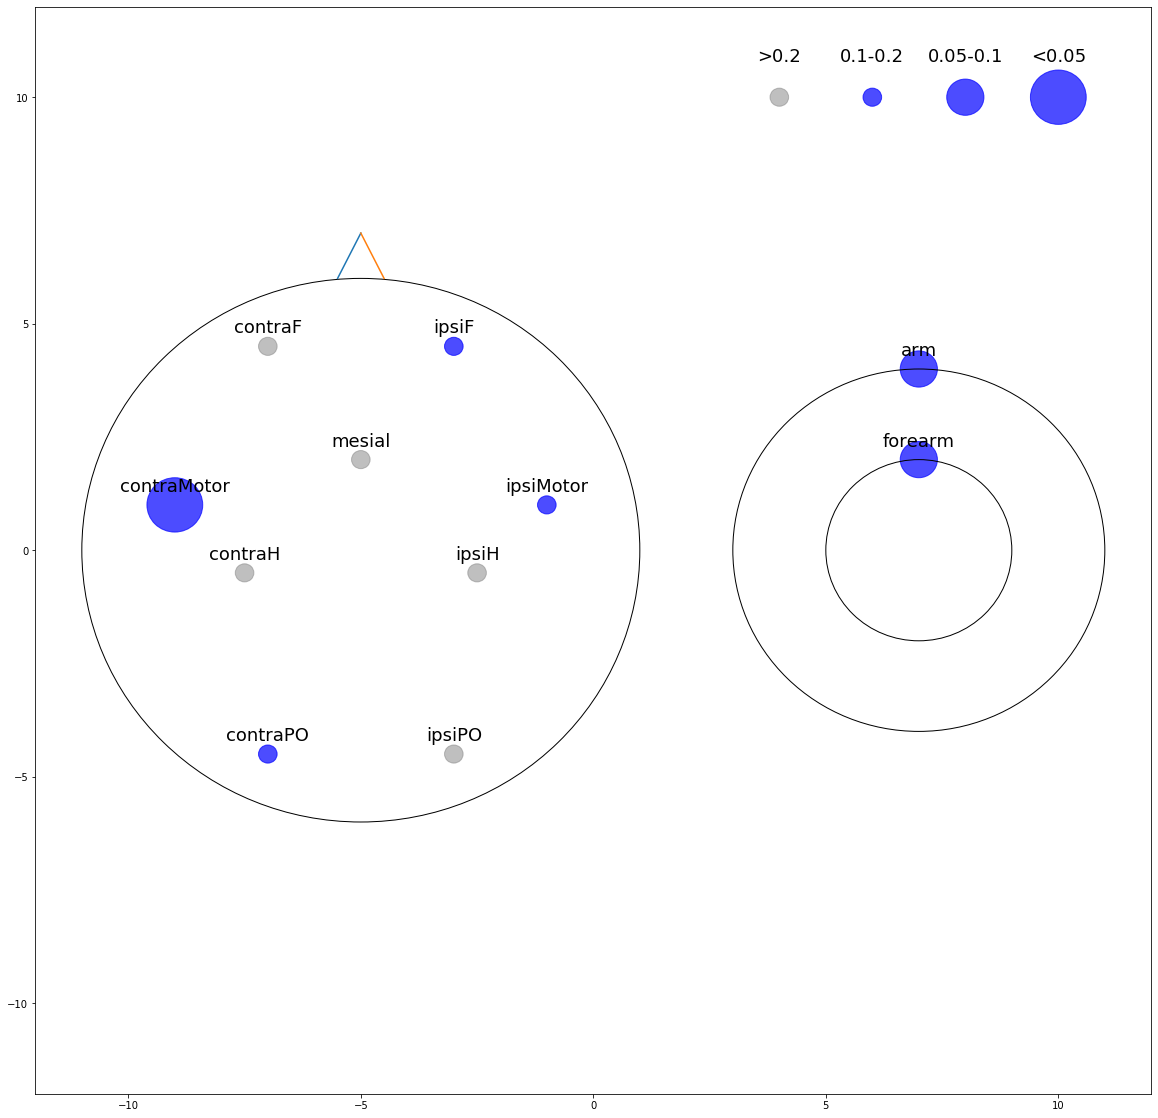

In [48]:
#visualisation - degreeC
pvalue_levels = [0.2,0.1,0.05]
def radiusBasedOnP (pvalue, defaultR=0.2):
    radius = None
    for level_idx in range(len(pvalue_levels)):
        if pvalue <= pvalue_levels[level_idx]:
            if radius == None:
                radius = defaultR
            else: 
                radius += defaultR
        else:
            return radius
    return radius


fig,ax = plt.subplots(figsize=(20, 20))
ax = plt.gca()
# EEG_group
center=[-5,0]
radius=6
circle = plt.Circle((center[0],center[1]),radius,fill = False)
ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.add_artist(circle)
#EEG_chs

EMGs=[EMGChannel(2,90,'forearm'),EMGChannel(4,90,'arm')]

EEGs = [EEGChannel(x=-2, y=4.5, name = 'contraF'), EEGChannel(x=-4, y=1, name = 'contraMotor'), 
        EEGChannel(x=-2, y=-4.5, name = 'contraPO'), EEGChannel(x=0, y=2, name = 'mesial'),
       EEGChannel(x=2, y=4.5, name = 'ipsiF'),EEGChannel(x=4, y=1, name = 'ipsiMotor'),
       EEGChannel(x=2, y=-4.5, name = 'ipsiPO'),EEGChannel(x=2.5, y=-0.5, name = 'ipsiH'),
       EEGChannel(x=-2.5, y=-0.5, name = 'contraH')] 

for EEG in EEGs:
    radius = radiusBasedOnP(p_groupC[EEG.name+'_degreeC'])
    if radius == None:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EEG.name, xy=(center[0]+EEG.x, center[1]+EEG.y+0.3), fontsize=18, color ='black', ha="center")

#EMG
center=[7,0]
for i in range(2):
    circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
    ax.add_artist(circle)
#EMG_chs
for EMG in EMGs:
    radius = radiusBasedOnP(p_groupC[EMG.name+'_degreeC'])
    if radius == None:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EMG.name, xy=(center[0]+EMG.x, center[1]+EMG.y+0.3), fontsize=18, color ='black', ha="center")
    
plt.xlim(-12,12)
plt.ylim(-12,12)


circle = plt.Circle((4,10), radius=0.2,fill = True, color = 'grey',alpha=0.5)
ax.add_patch(circle)
ax.annotate('>'+str(pvalue_levels[0]), xy=(4,10.8), fontsize=18, color ='black', ha="center")
increment = 0
for pvalue_level in pvalue_levels[1:]:
    increment+=1
    circle = plt.Circle((4+increment*2,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(str(pvalue_levels[increment])+'-'+str(pvalue_levels[increment-1]),
                xy=(4+increment*2,10.8), fontsize=18, color ='black', ha="center")
    
increment+=1    
circle = plt.Circle((4+2*increment,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
ax.add_patch(circle)
ax.annotate('<'+str(pvalue_levels[-1]), xy=(4+2*increment,10.8), 
            fontsize=18, color ='black', ha="center")

# save fig
# fName = os.path.join(preVsPostTMS_results_dir,'group_degree_centrality_topo.eps')
# plt.savefig(fName)

Text(10, 10.8, '<0.05')

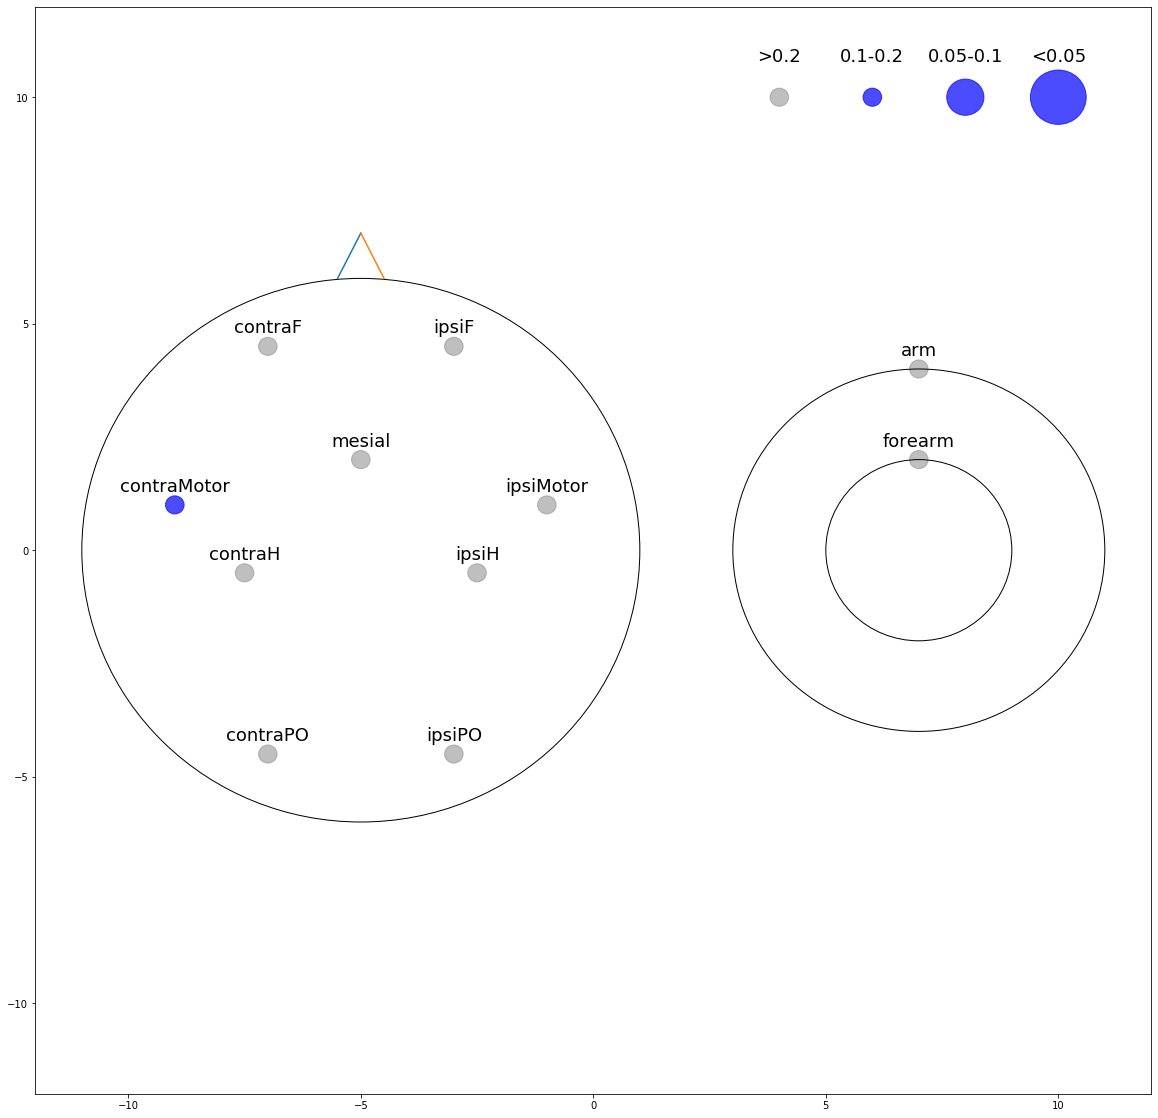

In [16]:
#visualisation - betweenness
pvalue_levels = [0.2,0.1,0.05]
def radiusBasedOnP (pvalue, defaultR=0.2):
    radius = None
    for level_idx in range(len(pvalue_levels)):
        if pvalue <= pvalue_levels[level_idx]:
            if radius == None:
                radius = defaultR
            else: 
                radius += defaultR
        else:
            return radius
    return radius


fig,ax = plt.subplots(figsize=(20, 20))
ax = plt.gca()
# EEG_group
center=[-5,0]
radius=6
circle = plt.Circle((center[0],center[1]),radius,fill = False)
ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.add_artist(circle)
#EEG_chs

EMGs=[EMGChannel(2,90,'forearm'),EMGChannel(4,90,'arm')]

EEGs = [EEGChannel(x=-2, y=4.5, name = 'contraF'), EEGChannel(x=-4, y=1, name = 'contraMotor'), 
        EEGChannel(x=-2, y=-4.5, name = 'contraPO'), EEGChannel(x=0, y=2, name = 'mesial'),
       EEGChannel(x=2, y=4.5, name = 'ipsiF'),EEGChannel(x=4, y=1, name = 'ipsiMotor'),
       EEGChannel(x=2, y=-4.5, name = 'ipsiPO'),EEGChannel(x=2.5, y=-0.5, name = 'ipsiH'),
       EEGChannel(x=-2.5, y=-0.5, name = 'contraH')] 

for EEG in EEGs:
    radius = radiusBasedOnP(p_groupC[EEG.name+'_betweennessC'])
    if radius == None:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EEG.name, xy=(center[0]+EEG.x, center[1]+EEG.y+0.3), fontsize=18, color ='black', ha="center")

#EMG
center=[7,0]
for i in range(2):
    circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
    ax.add_artist(circle)
#EMG_chs
for EMG in EMGs:
    radius = radiusBasedOnP(p_groupC[EMG.name+'_betweennessC'])
    if radius == None:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EMG.name, xy=(center[0]+EMG.x, center[1]+EMG.y+0.3), fontsize=18, color ='black', ha="center")
    
plt.xlim(-12,12)
plt.ylim(-12,12)


circle = plt.Circle((4,10), radius=0.2,fill = True, color = 'grey',alpha=0.5)
ax.add_patch(circle)
ax.annotate('>'+str(pvalue_levels[0]), xy=(4,10.8), fontsize=18, color ='black', ha="center")
increment = 0
for pvalue_level in pvalue_levels[1:]:
    increment+=1
    circle = plt.Circle((4+increment*2,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(str(pvalue_levels[increment])+'-'+str(pvalue_levels[increment-1]),
                xy=(4+increment*2,10.8), fontsize=18, color ='black', ha="center")
    
increment+=1    
circle = plt.Circle((4+2*increment,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
ax.add_patch(circle)
ax.annotate('<'+str(pvalue_levels[-1]), xy=(4+2*increment,10.8), 
            fontsize=18, color ='black', ha="center")

# save fig
# fName = os.path.join(strokeVsHealthy_results_dir,'betweenness_centrality_topo.eps')
# plt.savefig(fName)

Text(10, 10.8, '<0.05')

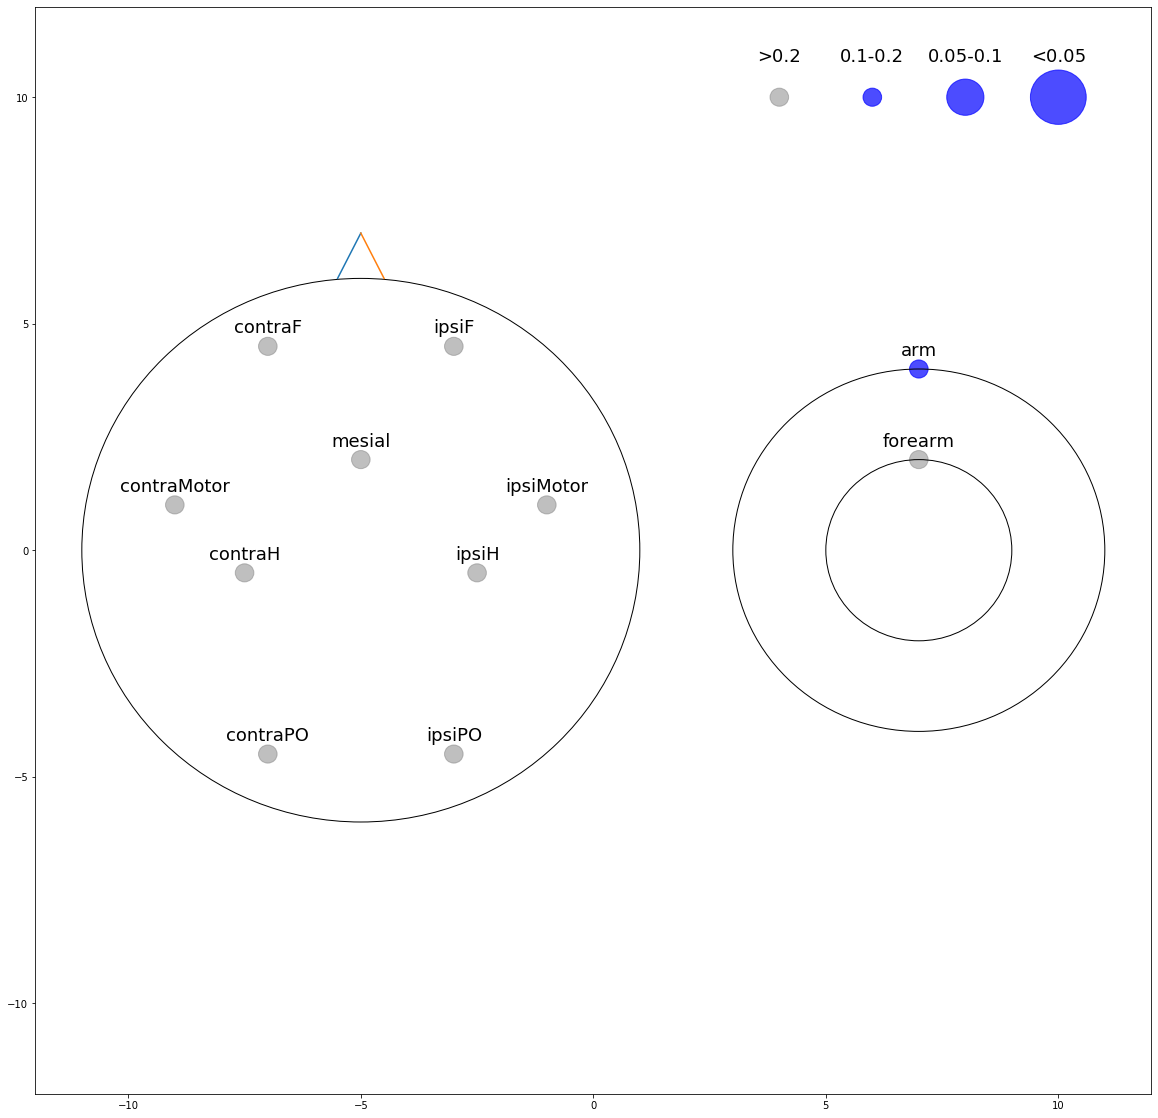

In [17]:
#visualisation - closeness
pvalue_levels = [0.2,0.1,0.05]
def radiusBasedOnP (pvalue, defaultR=0.2):
    radius = None
    for level_idx in range(len(pvalue_levels)):
        if pvalue <= pvalue_levels[level_idx]:
            if radius == None:
                radius = defaultR
            else: 
                radius += defaultR
        else:
            return radius
    return radius


fig,ax = plt.subplots(figsize=(20, 20))
ax = plt.gca()
# EEG_group
center=[-5,0]
radius=6
circle = plt.Circle((center[0],center[1]),radius,fill = False)
ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.add_artist(circle)
#EEG_chs

EMGs=[EMGChannel(2,90,'forearm'),EMGChannel(4,90,'arm')]

EEGs = [EEGChannel(x=-2, y=4.5, name = 'contraF'), EEGChannel(x=-4, y=1, name = 'contraMotor'), 
        EEGChannel(x=-2, y=-4.5, name = 'contraPO'), EEGChannel(x=0, y=2, name = 'mesial'),
       EEGChannel(x=2, y=4.5, name = 'ipsiF'),EEGChannel(x=4, y=1, name = 'ipsiMotor'),
       EEGChannel(x=2, y=-4.5, name = 'ipsiPO'),EEGChannel(x=2.5, y=-0.5, name = 'ipsiH'),
       EEGChannel(x=-2.5, y=-0.5, name = 'contraH')]  

for EEG in EEGs:
    radius = radiusBasedOnP(p_groupC[EEG.name+'_closenessC'])
    if radius == None:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EEG.name, xy=(center[0]+EEG.x, center[1]+EEG.y+0.3), fontsize=18, color ='black', ha="center")

#EMG
center=[7,0]
for i in range(2):
    circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
    ax.add_artist(circle)
#EMG_chs
for EMG in EMGs:
    radius = radiusBasedOnP(p_groupC[EMG.name+'_closenessC'])
    if radius == None:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EMG.name, xy=(center[0]+EMG.x, center[1]+EMG.y+0.3), fontsize=18, color ='black', ha="center")
    
plt.xlim(-12,12)
plt.ylim(-12,12)


circle = plt.Circle((4,10), radius=0.2,fill = True, color = 'grey',alpha=0.5)
ax.add_patch(circle)
ax.annotate('>'+str(pvalue_levels[0]), xy=(4,10.8), fontsize=18, color ='black', ha="center")
increment = 0
for pvalue_level in pvalue_levels[1:]:
    increment+=1
    circle = plt.Circle((4+increment*2,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(str(pvalue_levels[increment])+'-'+str(pvalue_levels[increment-1]),
                xy=(4+increment*2,10.8), fontsize=18, color ='black', ha="center")
    
increment+=1    
circle = plt.Circle((4+2*increment,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
ax.add_patch(circle)
ax.annotate('<'+str(pvalue_levels[-1]), xy=(4+2*increment,10.8), 
            fontsize=18, color ='black', ha="center")

# save fig
# fName = os.path.join(strokeVsHealthy_results_dir,'betweenness_centrality_topo.eps')
# plt.savefig(fName)

Text(10, 10.8, '<0.05')

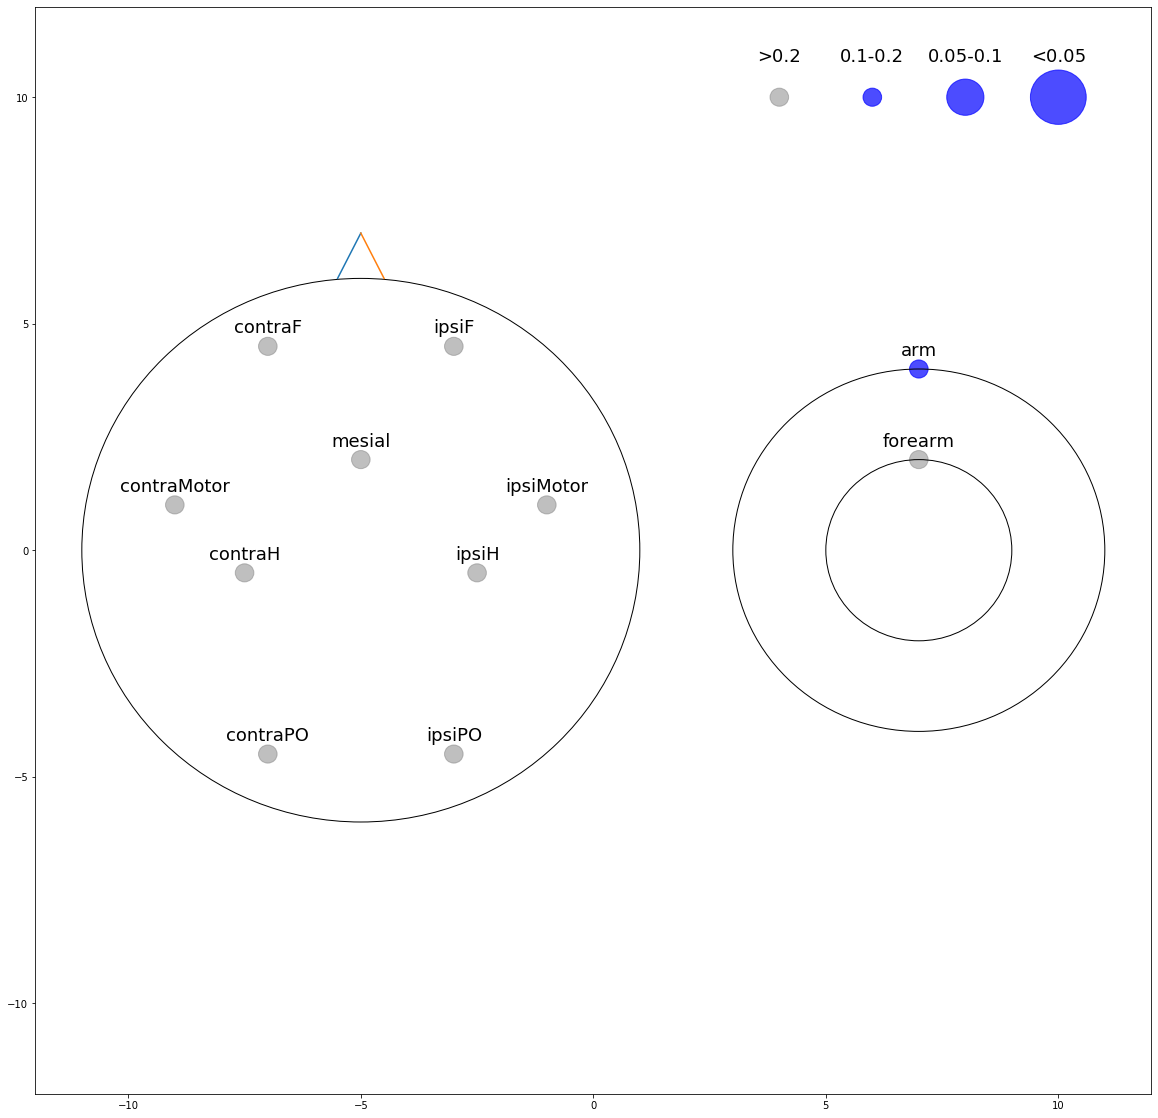

In [18]:
# cost_closeness _cost_closenessC
#visualisation
pvalue_levels = [0.2,0.1,0.05]
def radiusBasedOnP (pvalue, defaultR=0.2):
    radius = None
    for level_idx in range(len(pvalue_levels)):
        if pvalue <= pvalue_levels[level_idx]:
            if radius == None:
                radius = defaultR
            else: 
                radius += defaultR
        else:
            return radius
    return radius


fig,ax = plt.subplots(figsize=(20, 20))
ax = plt.gca()
# EEG_group
center=[-5,0]
radius=6
circle = plt.Circle((center[0],center[1]),radius,fill = False)
ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.add_artist(circle)
#EEG_chs

EMGs=[EMGChannel(2,90,'forearm'),EMGChannel(4,90,'arm')]

EEGs = [EEGChannel(x=-2, y=4.5, name = 'contraF'), EEGChannel(x=-4, y=1, name = 'contraMotor'), 
        EEGChannel(x=-2, y=-4.5, name = 'contraPO'), EEGChannel(x=0, y=2, name = 'mesial'),
       EEGChannel(x=2, y=4.5, name = 'ipsiF'),EEGChannel(x=4, y=1, name = 'ipsiMotor'),
       EEGChannel(x=2, y=-4.5, name = 'ipsiPO'),EEGChannel(x=2.5, y=-0.5, name = 'ipsiH'),
       EEGChannel(x=-2.5, y=-0.5, name = 'contraH')]

for EEG in EEGs:
    radius = radiusBasedOnP(p_groupC[EEG.name+'_cost_closenessC'])
    if radius == None:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EEG.name, xy=(center[0]+EEG.x, center[1]+EEG.y+0.3), fontsize=18, color ='black', ha="center")

#EMG
center=[7,0]
for i in range(2):
    circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
    ax.add_artist(circle)
#EMG_chs
for EMG in EMGs:
    radius = radiusBasedOnP(p_groupC[EMG.name+'_cost_closenessC'])
    if radius == None:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EMG.name, xy=(center[0]+EMG.x, center[1]+EMG.y+0.3), fontsize=18, color ='black', ha="center")
    
plt.xlim(-12,12)
plt.ylim(-12,12)


circle = plt.Circle((4,10), radius=0.2,fill = True, color = 'grey',alpha=0.5)
ax.add_patch(circle)
ax.annotate('>'+str(pvalue_levels[0]), xy=(4,10.8), fontsize=18, color ='black', ha="center")
increment = 0
for pvalue_level in pvalue_levels[1:]:
    increment+=1
    circle = plt.Circle((4+increment*2,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(str(pvalue_levels[increment])+'-'+str(pvalue_levels[increment-1]),
                xy=(4+increment*2,10.8), fontsize=18, color ='black', ha="center")
    
increment+=1    
circle = plt.Circle((4+2*increment,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
ax.add_patch(circle)
ax.annotate('<'+str(pvalue_levels[-1]), xy=(4+2*increment,10.8), 
            fontsize=18, color ='black', ha="center")

# save fig
# fName = os.path.join(strokeVsHealthy_results_dir,'betweenness_centrality_topo.eps')
# plt.savefig(fName)

Text(10, 10.8, '<0.05')

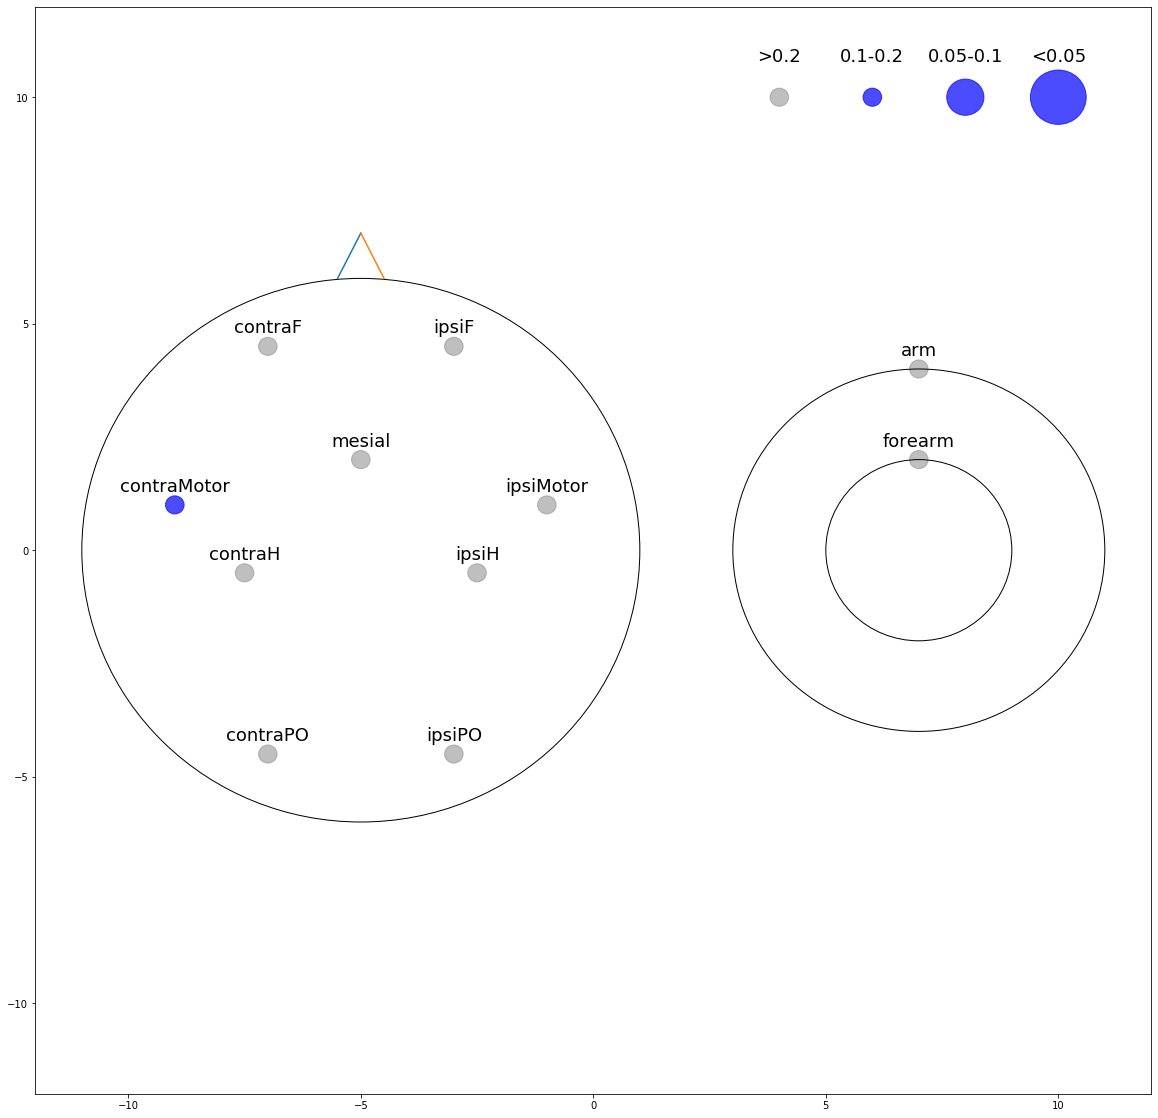

In [19]:
# cost_betweennessC
#visualisation 
pvalue_levels = [0.2,0.1,0.05]
def radiusBasedOnP (pvalue, defaultR=0.2):
    radius = None
    for level_idx in range(len(pvalue_levels)):
        if pvalue <= pvalue_levels[level_idx]:
            if radius == None:
                radius = defaultR
            else: 
                radius += defaultR
        else:
            return radius
    return radius


fig,ax = plt.subplots(figsize=(20, 20))
ax = plt.gca()
# EEG_group
center=[-5,0]
radius=6
circle = plt.Circle((center[0],center[1]),radius,fill = False)
ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
ax.add_artist(circle)
#EEG_chs

EMGs=[EMGChannel(2,90,'forearm'),EMGChannel(4,90,'arm')]

EEGs = [EEGChannel(x=-2, y=4.5, name = 'contraF'), EEGChannel(x=-4, y=1, name = 'contraMotor'), 
        EEGChannel(x=-2, y=-4.5, name = 'contraPO'), EEGChannel(x=0, y=2, name = 'mesial'),
       EEGChannel(x=2, y=4.5, name = 'ipsiF'),EEGChannel(x=4, y=1, name = 'ipsiMotor'),
       EEGChannel(x=2, y=-4.5, name = 'ipsiPO'),EEGChannel(x=2.5, y=-0.5, name = 'ipsiH'),
       EEGChannel(x=-2.5, y=-0.5, name = 'contraH')]

for EEG in EEGs:
    radius = radiusBasedOnP(p_groupC[EEG.name+'_cost_betweennessC'])
    if radius == None:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EEG.x, center[1]+EEG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EEG.name, xy=(center[0]+EEG.x, center[1]+EEG.y+0.3), fontsize=18, color ='black', ha="center")

#EMG
center=[7,0]
for i in range(2):
    circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
    ax.add_artist(circle)
#EMG_chs
for EMG in EMGs:
    radius = radiusBasedOnP(p_groupC[EMG.name+'_cost_betweennessC'])
    if radius == None:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=0.2,fill = True, color = 'grey',alpha=0.5)
    else:
        circle = plt.Circle((center[0]+EMG.x, center[1]+EMG.y), radius=radius,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    label = ax.annotate(EMG.name, xy=(center[0]+EMG.x, center[1]+EMG.y+0.3), fontsize=18, color ='black', ha="center")
    
plt.xlim(-12,12)
plt.ylim(-12,12)


circle = plt.Circle((4,10), radius=0.2,fill = True, color = 'grey',alpha=0.5)
ax.add_patch(circle)
ax.annotate('>'+str(pvalue_levels[0]), xy=(4,10.8), fontsize=18, color ='black', ha="center")
increment = 0
for pvalue_level in pvalue_levels[1:]:
    increment+=1
    circle = plt.Circle((4+increment*2,10), radius=0.2*increment,fill = True, color = 'blue',alpha=0.7)
    ax.add_patch(circle)
    ax.annotate(str(pvalue_levels[increment])+'-'+str(pvalue_levels[increment-1]),
                xy=(4+increment*2,10.8), fontsize=18, color ='black', ha="center")
    
increment+=1    
circle = plt.Circle((4+2*increment,10), radius=0.2*increment,fill= True, color = 'blue',alpha=0.7)
ax.add_patch(circle)
ax.annotate('<'+str(pvalue_levels[-1]), xy=(4+2*increment,10.8), 
            fontsize=18, color ='black', ha="center")

# save fig
# fName = os.path.join(strokeVsHealthy_results_dir,'betweenness_centrality_topo.eps')
# plt.savefig(fName)

## correlation between FMA/rMT and graph features